#  <b>Limited Proteolysis of HeLa Cell Lysates by Tyler T. Cooper, PhD</b>

### Libraries

In [1]:
### Data Handling
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from scipy.stats import pearsonr
pd.options.display.max_columns = None
#pd.options.display.max_rows = None
from itertools import combinations
import re
#

#Statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Figure Generation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import offsetbox
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import axes3d
from IPython.display import Image, display
import seaborn as sns
from adjustText import adjust_text
import glob
import bioinfokit
from bioinfokit import analys, visuz

#Venn Diagrams
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
%matplotlib inline

cmap = 'PRGn'
fmt='eps'
dpi=600

In [2]:
print('The numpy version is {}.'.format(np.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The matplotlib version is {}.'.format(matplotlib.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

The numpy version is 1.19.1.
The pandas version is 1.0.5.
The matplotlib version is 3.2.2.
The seaborn version is 0.11.0.


# <b>Section 1: Analysis of Peptides</b>

In [3]:
def PEAKS_Importer(csv,drop_OG=True):
    df=pd.read_csv(csv)
    df[["Protein","Y"]]=df['Protein Accession'].str.split("|",1,expand=True)
    df[["Gene","Species"]]=df['Y'].str.split("_",1,expand=True)
    if drop_OG==True:
        df.drop(columns=['Y', 'Protein Accession',"Found By"], inplace=True)
    else:
        df.drop(columns=['Y',"Found By"], inplace=True)
    return(df)

In [4]:
og_pep=PEAKS_Importer("protein-peptides_1in50only.csv")
og_pep

,Protein Group,Protein ID,Peptide,Unique,Score (%),-10lgP,Mass,Length,ppm,m/z,z,RT,Area Tryp_1hr_1:50_Rep1,Area Tryp_1hr_1:50_Rep2,Area Tryp_18hr_1:50_Rep1,Area AspN_1hr_1:50_Rep1,Area AspN_1hr_1:50_Rep2,Area AspN_18hr_1:50_Rep1,Area AspN_18hr_1:50_Rep2,Area GluC_1hr_1:50_Rep1,Area GluC_1hr_1:50_Rep2,Area GluC_18hr_1:50_Rep1,Area GluC_18hr_1:50_Rep2,Area Trypsin_18hr_1:50_Rep2,Fraction,Scan,Source File,#Feature,#Feature Tryp_1hr_1:50_Rep1,#Feature Tryp_1hr_1:50_Rep2,#Feature Tryp_18hr_1:50_Rep1,#Feature AspN_1hr_1:50_Rep1,#Feature AspN_1hr_1:50_Rep2,#Feature AspN_18hr_1:50_Rep1,#Feature AspN_18hr_1:50_Rep2,#Feature GluC_1hr_1:50_Rep1,#Feature GluC_1hr_1:50_Rep2,#Feature GluC_18hr_1:50_Rep1,#Feature GluC_18hr_1:50_Rep2,#Feature Trypsin_18hr_1:50_Rep2,Start,End,PTM,AScore,Protein,Gene,Species
0,1,42,L.DKKVEKVTISNRLVSSPC(+57.02)C(+57.02)IVTSTYGWT...,Y,100.0,125.61,4741.4175,41,1.4,949.2921,5,215.58,NaN,NaN,NaN,26069000.0,NaN,83391000.0,NaN,NaN,NaN,NaN,NaN,NaN,6,F6:114936,tc_28Oct2020_18hrAspN1in50_HeLa_500ng_290minTC...,6,0,0,0,3,0,3,0,0,0,0,0,0,572,612,Carbamidomethylation; Deamidation (NQ),C18:Carbamidomethylation:1000.00;C19:Carbamido...,P08238,HS90B,HUMAN
1,1,42,L.DKKVEKVTISNRLVSSPC(+57.02)C(+57.02)IVTSTYGWT...,Y,100.0,121.69,4740.4336,41,-1.3,791.0785,6,213.93,NaN,NaN,NaN,339740000.0,563730000.0,303560000.0,183390000.0,NaN,NaN,NaN,NaN,NaN,4,F4:107863,tc_26Oct2020_1hrAspN1in50_HeLa_500ng_290minTC_...,15,0,0,0,3,5,3,4,0,0,0,0,0,572,612,Carbamidomethylation,C18:Carbamidomethylation:1000.00;C19:Carbamido...,P08238,HS90B,HUMAN
2,1,42,M.PEEVHHGEEEVETFAFQAEIAQLMSLIINTFYSNKEIFLRELIS...,Y,100.0,116.27,5422.6704,47,-0.5,1085.5408,5,250.64,NaN,NaN,NaN,3723800.0,849160.0,3638700.0,1030200.0,NaN,NaN,NaN,NaN,NaN,5,F5:131414,tc_15Nov2020_1hrAspN1in50_HeLa_500ng_290min_Re...,6,0,0,0,2,1,2,1,0,0,0,0,0,2,48,NaN,NaN,P08238,HS90B,HUMAN
3,1,42,R.DNSTMGYMMAKKHLEINPDHPIVETLRQ(+.98)KAEA.D,Y,100.0,112.41,3667.7795,32,-0.1,917.9521,4,149.94,NaN,NaN,NaN,196410000.0,NaN,297640000.0,NaN,NaN,NaN,NaN,NaN,NaN,6,F6:80159,tc_28Oct2020_18hrAspN1in50_HeLa_500ng_290minTC...,5,0,0,0,3,0,2,0,0,0,0,0,0,613,644,Deamidation (NQ),Q28:Deamidation (NQ):115.60,P08238,HS90B,HUMAN
4,1,42,K.HNDDEQYAWESSAGGSFTVR.A,N,100.0,111.18,2254.9514,20,0.4,1128.4834,2,136.17,1.180000e+09,1.176400e+09,2.468800e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,884260000.0,23,F23:73418,tc_16Nov2020_18hrTryp1in50_HeLa_500ng_290min_R...,57,17,17,13,0,0,0,0,0,0,0,0,10,149,168,NaN,NaN,P08238,HS90B,HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144286,5255,5322,E.NIARLLFQE.D,Y,96.3,27.39,1102.6134,9,-11.5,552.3076,2,152.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7847500.0,NaN,11,F11:77227,tc_16Nov2020_18hrGluC1in50_HeLa_500ng_290min_R...,1,0,0,0,0,0,0,0,0,0,0,1,0,1359,1367,NaN,NaN,Q9P2D7,DYH1,HUMAN
144287,5786,5276,E.KNILPVDSSVKE.A,Y,95.2,27.38,1327.7347,12,-0.6,443.5852,3,80.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2076900.0,NaN,NaN,NaN,NaN,8,F8:37966,tc_27Oct2020_1hrGluC1in50_HeLa_500ng_290minTC_...,1,0,0,0,0,0,0,0,1,0,0,0,0,146,157,NaN,NaN,Q9ULH7,MRTFB,HUMAN
144288,5635,6094,E.RSGPLASPVLLE.T,Y,94.9,27.36,1237.7030,12,0.7,619.8592,2,136.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1734800.0,NaN,NaN,10,F10:73024,tc_27Oct2020_18hrGluC1in50_HeLa_500ng_290minTC...,1,0,0,0,0,0,0,0,0,0,1,0,0,1458,1469,NaN,NaN,Q9UPS6,SET1B,HUMAN
144289,5488,6047,MKVTVC(+57.02)FGRTRVVVPC(+57.02)GDGHM(+15.99)K...,Y,93.4,27.36,4622.4697,40,17.7,771.4325,6,226.56,NaN,NaN,NaN,NaN,5612400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,F5:119307,tc_15Nov2020_1hrAspN1in50_HeLa_500ng_290min_Re...,1,0,0,0,0,1,0,0,0,0,0,0,0,1,40,Carbamidomethylation; Oxidation (M),C6:Carbamidomethylation:1000.00;C16:Carbamidom...,Q8TEW0,PARD3,HUMAN


## Hydrophibicity Calculator (Sum, Sum Normalized to Peptide Length, 

In [5]:
#### Code for isoelectric point was adopted and modified from Kozlowski LP (2016) IPC - Isoelectric Point Calculator. Biology Direct 11:55. doi: http://dx.doi.org/10.1186/s13062-016-0159-9)

In [6]:
# to ad new pKa sets just add new dictionary       
scales = {
"EMBOSS":     {'Cterm': 3.6, 'pKAsp': 3.9,  'pKGlu': 4.1, 'pKCys': 8.5, 'pKTyr': 10.1, 'pk_his': 6.5, 'Nterm': 8.6, 'pKLys': 10.8, 'pKArg': 12.5},
"DTASelect":  {'Cterm': 3.1, 'pKAsp': 4.4,  'pKGlu': 4.4, 'pKCys': 8.5, 'pKTyr': 10.0, 'pk_his': 6.5, 'Nterm': 8.0, 'pKLys': 10.0, 'pKArg': 12.0},
"Solomon":    {'Cterm': 2.4, 'pKAsp': 3.9,  'pKGlu': 4.3, 'pKCys': 8.3, 'pKTyr': 10.1, 'pk_his': 6.0, 'Nterm': 9.6, 'pKLys': 10.5, 'pKArg': 12.5}, 
"Sillero":    {'Cterm': 3.2, 'pKAsp': 4.0,  'pKGlu': 4.5, 'pKCys': 9.0, 'pKTyr': 10.0, 'pk_his': 6.4, 'Nterm': 8.2, 'pKLys': 10.4, 'pKArg': 12.0},
"Rodwell":    {'Cterm': 3.1, 'pKAsp': 3.68, 'pKGlu': 4.25,'pKCys': 8.33,'pKTyr': 10.07,'pk_his': 6.0, 'Nterm': 8.0, 'pKLys': 11.5, 'pKArg': 11.5},
"Patrickios": {'Cterm': 4.2, 'pKAsp': 4.2,  'pKGlu': 4.2, 'pKCys': 0.0, 'pKTyr':  0.0, 'pk_his': 0.0, 'Nterm': 11.2,'pKLys': 11.2, 'pKArg': 11.2},
"Wikipedia":  {'Cterm': 3.65,'pKAsp': 3.9,  'pKGlu': 4.07,'pKCys': 8.18,'pKTyr': 10.46,'pk_his': 6.04,'Nterm': 8.2, 'pKLys': 10.54,'pKArg': 12.48},
"Grimsley":   {'Cterm': 3.3, 'pKAsp': 3.5,  'pKGlu': 4.2, 'pKCys': 6.8, 'pKTyr': 10.3, 'pk_his': 6.6, 'Nterm': 7.7, 'pKLys': 10.5, 'pKArg': 12.04},
'Lehninger':  {'Cterm': 2.34,'pKAsp': 3.86, 'pKGlu': 4.25,'pKCys': 8.33,'pKTyr': 10.0, 'pk_his': 6.0, 'Nterm': 9.69,'pKLys': 10.5, 'pKArg': 12.4},
'Bjellqvist': {'Cterm': 3.55,'pKAsp': 4.05, 'pKGlu': 4.45,'pKCys': 9.0, 'pKTyr': 10.0, 'pk_his': 5.98,'Nterm': 7.5, 'pKLys': 10.0, 'pKArg': 12.0},   
'IPC_peptide':{'Cterm': 2.383, 'pKAsp': 3.887, 'pKGlu': 4.317, 'pKCys': 8.297, 'pKTyr': 10.071, 'pk_his': 6.018, 'Nterm': 9.564, 'pKLys': 10.517, 'pKArg': 12.503},    
'IPC_protein':{'Cterm': 2.869, 'pKAsp': 3.872, 'pKGlu': 4.412, 'pKCys': 7.555, 'pKTyr': 10.85,  'pk_his': 5.637, 'Nterm': 9.094, 'pKLys': 9.052,  'pKArg': 11.84},     
'Toseland':   {'Cterm': 3.19,'pKAsp': 3.6,  'pKGlu': 4.29,'pKCys': 6.87,'pKTyr': 9.61, 'pk_his': 6.33,'Nterm': 8.71, 'pKLys': 10.45, 'pKArg':  12},
'Thurlkill':  {'Cterm': 3.67,'pKAsp': 3.67, 'pKGlu': 4.25,'pKCys': 8.55,'pKTyr': 9.84, 'pk_his': 6.54,'Nterm': 8.0, 'pKLys': 10.4, 'pKArg': 12.0},
'Nozaki':     {'Cterm': 3.8, 'pKAsp': 4.0,  'pKGlu': 4.4, 'pKCys': 9.5, 'pKTyr': 9.6,  'pk_his': 6.3, 'Nterm': 7.5, 'pKLys': 10.4, 'pKArg': 12},   
'Dawson':     {'Cterm': 3.2, 'pKAsp': 3.9,  'pKGlu': 4.3, 'pKCys': 8.3, 'pKTyr': 10.1, 'pk_his': 6.0, 'Nterm': 8.2, 'pKLys': 10.5, 'pKArg':  12},   
          }

aaDict = {'Asp':'D', 'Glu':'E', 'Cys':'C', 'Tyr':'Y', 'His':'H', 
          'Lys':'K', 'Arg':'R', 'Met':'M', 'Phe':'F', 'Leu':'L', 
          'Val':'V', 'Ala':'A', 'Gly':'G', 'Gln':'Q', 'Asn':'N',
          'Ile':'I', 'Trp':'W', 'Ser':'S', 'Thr':'T', 'Sec':'U',
          'Pro':'P', 'Xaa':'X', 'Sec':'U', 'Pyl':'O', 'Asx':'B',
          'Xle':'J', }

acidic = ['D', 'E', 'C', 'Y']
basic = ['K', 'R', 'H']

pKcterminal = {'D': 4.55, 'E': 4.75} 
pKnterminal = {'A': 7.59, 'M': 7.0, 'S': 6.93, 'P': 8.36, 'T': 6.82, 'V': 7.44, 'E': 7.7} 


#### Scale Selection

In [7]:
scale='IPC_peptide'
def isoelectric_point(seq, scale=scale):
    pKCterm = scales[scale]['Cterm']
    pKAsp = scales[scale]['pKAsp']
    pKGlu = scales[scale]['pKGlu']
    pKCys = scales[scale]['pKCys']
    pKTyr = scales[scale]['pKTyr']
    pKHis = scales[scale]['pk_his']
    pKNterm = scales[scale]['Nterm']
    pKLys = scales[scale]['pKLys'] 
    pKArg = scales[scale]['pKArg']
    pH = 6.51             #starting po pI = 6.5 - theoretically it should be 7, but average protein pI is 6.5 so we increase the probability of finding the solution
    pHprev = 0.0         
    pHnext = 14.0        
    E = 0.01             #epsilon means precision [pI = pH +- E]
    temp = 0.01
    nterm=seq[0]
    while 1:             #the infinite loop
        QN1=-1.0/(1.0+pow(10,(pKCterm-pH)))                                        
        QN2=-seq.count('D')/(1.0+pow(10,(pKAsp-pH)))           
        QN3=-seq.count('E')/(1.0+pow(10,(pKGlu-pH)))           
        QN4=-seq.count('C')/(1.0+pow(10,(pKCys-pH)))           
        QN5=-seq.count('Y')/(1.0+pow(10,(pKTyr-pH)))        
        QP1=seq.count('H')/(1.0+pow(10,(pH-pKHis)))            
        QP2=1.0/(1.0+pow(10,(pH-pKNterm)))                
        QP3=seq.count('K')/(1.0+pow(10,(pH-pKLys)))           
        QP4=seq.count('R')/(1.0+pow(10,(pH-pKArg)))            
        NQ=QN1+QN2+QN3+QN4+QN5+QP1+QP2+QP3+QP4
        #print NQ
        #%%%%%%%%%%%%%%%%%%%%%%%%%   BISECTION   %%%%%%%%%%%%%%%%%%%%%%%%
        if NQ<0.0:              #we are out of range, thus the new pH value must be smaller                     
            temp = pH
            pH = pH-((pH-pHprev)/2.0)
            pHnext = temp
            #print "pH: ", pH, ", \tpHnext: ",pHnext
        else:
            temp = pH
            pH = pH + ((pHnext-pH)/2.0)
            pHprev = temp
            #print "pH: ", pH, ",\tpHprev: ", pHprev

        if (pH-pHprev<E) and (pHnext-pH<E): #terminal condition, finding pI with given precision
            return pH

#### Hydrophobicity_score = Hydro_Sum

In [8]:
def hydrophobicity_score(peptide):
    hydro = {     "A": 1.800,
    "R": -4.500,
    "N": -3.500,
    "D": -3.500,
    "C": 2.500,
    "Q": -3.500,
    "E": -3.500,
    "G": -0.400,
    "H": -3.200,
    "I": 4.500,
    "L": 3.800,
    "K": -3.900,
    "M": 1.900,
    "F": 2.800,
    "P": -1.600,
    "S": -0.800,
    "T": -0.700,
    "W": -0.900,
    "Y": -1.300,
    "V": 4.200,
    }
    hydro_score = [hydro.get(aa,0.0)for aa in peptide]
    return sum(hydro_score)

#### Neutral Charge Calculator

In [9]:
aa_z = {'E': -1, 'D': -1, 'K': 1, 'R': 1} 
#Charge of Amino Acids to Determine Overall Charge of Peptide
def overall_charge(sequence, z_dict=aa_z):
#Calculates the charge of the peptide sequence at neutral pH ~7.4
    peptide_charge = [z_dict.get(aa, 0.0) for aa in sequence]
    return sum(peptide_charge)


In [10]:
og_mz=og_pep[['Protein ID','Protein', 'Peptide','Gene','Mass','RT','Score (%)','m/z','z','Length']]


## Correlation of Peptide Variables - Whole Data Set

In [11]:
# og_corr=og_pep[['Mass','RT','Score (%)','m/z','z','Length','IPC','Neutral_Z', 'Hydro_Sum','Hydro_Sum_Norm']]

In [12]:
# plt.figure(figsize=(16, 6))
# # define the mask to set the values in the upper triangle to True
# mask = np.triu(np.ones_like(og_corr.corr(), dtype=np.bool))
# heatmap = sns.heatmap(og_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='PRGn')
# heatmap.set_title('Correlation Heatmap of Peptide Characteristics', fontdict={'fontsize':18}, pad=16);
# plt.savefig('Correlation_Heatmap',format=fmt,dpi=dpi,bbox_inches="tight")

In [13]:
### Functions ###

In [14]:
def Excel_Mapper(list_dfs, xls_path):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer,'sheet%s' % n)
        writer.save()

In [18]:
def Butcher(df,ident1=None,ident2=None,ident3=None,t_id1=None,t_id2=None,t_id3=None,t_value=0,acid=["J","Z"],labels=list(),excel_mapper=True,excel_name=None):
    raw=df.loc[:,df.columns.str.contains(ident1)]
    tag=df[labels]
    raw = pd.concat([raw, tag], axis=1)
    raw["Peptide"]= raw["Peptide"].str.replace('\W+',"")
    raw["Peptide"]= raw["Peptide"].str.replace('\d+',"")
    raw["Peptide"]= raw["Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)
    
    try:
        cut=raw.loc[:,raw.columns.str.contains(ident2)]
        cut=raw.loc[:,raw.columns.str.contains(ident3)]
    except:
        cut=raw.loc[:,raw.columns.str.contains(ident2)]
    cuts = pd.concat([cut, tag], axis=1)
#     cuts = cuts.filter(regex=t_id)
    cuts = cuts[(cuts.columns.str.contains(t_id) > t_value).any(axis=1)]
    cuts.reset_index(inplace=True)
    excels=[raw,cuts]
    Excel_Mapper(excels,excel_name +".xlsx")
    return raw, cuts

In [19]:
# def Butcher(df,ident1=None,ident2=None,ident3=None,t_id1=None,t_id2=None,t_id3=None,t_value=0,acid=tuple(),labels=list(),excel_mapper=True,excel_name=None):
#     raw=df.loc[:,df.columns.str.contains(ident1)]
#     tag=df[labels]
#     raw = pd.concat([raw, tag], axis=1)
#     raw["Peptide"]= raw["Peptide"].str.replace('\W+',"")
#     raw["Peptide"]= raw["Peptide"].str.replace('\d+',"")
#     raw["Peptide"]= raw["Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)
#     cut=raw.loc[:,raw.columns.str.contains(ident2)]
#     cuts = pd.concat([cut, tag], axis=1)
#     if t_id1 is None:
#         print("Select One Column for Filtering")
#     elif t_id3 is None:
#         try:
#             cuts=cuts.loc[(cuts[t_id1]>t_value)|(cuts[t_id2]>t_value)]
#         except:
#             cuts=cuts.loc[(cuts[t_id1]>t_value)]
#     else:
#         cuts=cuts.loc[(cuts[t_id1]>t_value)|(cuts[t_id2]>t_value)|(cuts[t_id3]>t_value)]
#     cuts["Peptide"]= cuts["Peptide"].str.replace('\W+',"")
#     cuts["Peptide"]= cuts["Peptide"].str.replace('\d+',"")
#     cuts["Peptide"]= cuts["Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)
#     cuts.reset_index(inplace=True)
#     excels=[raw,cuts]
#     Excel_Mapper(excels,excel_name +".xlsx")
#     return raw, cuts

In [20]:
peanut=['Protein ID','Protein', 'Peptide','Gene','Mass','RT','Score (%)','m/z','z','Length']

In [21]:
def Marinate (df,target,IPC=False,Hydro=False,GRAVY=False,NeutralZ=False):
    if IPC is True:
        df["IPC"]=df[target].apply(isoelectric_point)
    if Hydro is True:
        df["Hydro_Sum"]=df[target].apply(hydrophobicity_score)
        if GRAVY is True:
            df["GRAVY"]=df['Hydro_Sum'] / df['Length']
    if NeutralZ is True:
        df["Neutral_Z"]=df[target].apply(overall_charge) 
print("Peptides have been marinated!")
        

Peptides have been marinated!


## <b>Trypsin Peptide Analyses</b>

### Trypsin 1hr DataFrame Cleaning

In [18]:
# Selection of 1hr Trypsin 
x="Tryp"
y="1hr"
area1="Area Tryp_1hr_1:50_Rep1"
area2="Area Tryp_1hr_1:50_Rep2"
area3=None
acid=["L","K"]
excel_name="Tryp1hr_50"
Tryp, Tryp1_50=Butcher(og_pep,ident1=x,ident2=y,ident3=None,t_id="Area",t_value=0
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Marinate(Tryp1_50,"Peptide",IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

#Split Replicates
Tryp1_50_Rep1=Tryp1_50.loc[(Tryp1_50['Area Tryp_1hr_1:50_Rep1'] > 0)]
Tryp1_50_Rep2=Tryp1_50.loc[(Tryp1_50['Area Tryp_1hr_1:50_Rep2'] > 0)]

# #Copy Dataframe for Cross-Protein Analysis

T1_50_pep=Tryp1_50.copy()


In [19]:
Tryp1_50

,index,Area Tryp_1hr_1:50_Rep1,Area Tryp_1hr_1:50_Rep2,#Feature Tryp_1hr_1:50_Rep1,#Feature Tryp_1hr_1:50_Rep2,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,GRAVY,Neutral_Z
0,4,1.180000e+09,1.176400e+09,17,17,42,P08238,HNDDEQYAWESSAGGSFTVRA,HS90B,2254.9514,136.17,100.0,1128.4834,2,20,4.100537,-22.4,-1.120000,-3.0
1,7,1.432000e+09,2.016000e+09,6,5,42,P08238,RYHTSQSGDEMTSLSEYVSRM,HS90B,2175.9377,127.21,100.0,1088.9771,2,19,5.384736,-22.8,-1.200000,-1.0
2,8,2.262100e+09,3.040500e+09,13,23,42,P08238,VILHLKEDQTEYLEERR,HS90B,2014.0371,113.76,100.0,1008.0255,2,16,4.825283,-19.0,-1.187500,-2.0
3,10,2.261400e+09,2.755000e+09,6,3,42,P08238,HLEINPDHPIVETLRQ,HS90B,1781.9424,122.25,100.0,446.4927,4,15,5.219443,-11.5,-0.766667,-2.0
4,17,NaN,4.366200e+06,0,2,42,P08238,MPEEVHHGEEEVETFAFQAEIAQLMSLIINTFYSNKEIFLRE,HS90B,4708.3159,250.54,99.9,1178.0920,4,40,4.214971,-8.4,-0.210000,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48150,144248,NaN,5.101500e+06,0,1,10868,Q9NQ69,TLTTGDHFGMKDSLVYCRA,LHX9,2099.9768,134.32,97.2,526.0063,4,18,7.146357,-2.8,-0.155556,0.0
48151,144271,NaN,5.004300e+05,0,1,15608,Q6NW34,INVQNNVDLGQPVKN,NEPRO,1536.8259,94.88,97.1,769.4198,2,14,6.707490,-9.5,-0.678571,0.0
48152,144274,2.150400e+05,NaN,1,0,8222,Q9UK58,RILGCELIQAAGILLRL,CCNL1,1638.9491,240.22,96.8,547.3246,3,15,8.931084,21.8,1.453333,1.0
48153,144284,NaN,2.212300e+06,0,1,11575,Q96Q83,RTVYPDPRG,ALKB3,846.4235,56.83,97.0,424.2243,2,7,9.808818,-13.9,-1.985714,1.0


In [20]:
og_pep

,Protein Group,Protein ID,Peptide,Unique,Score (%),-10lgP,Mass,Length,ppm,m/z,z,RT,Area Tryp_1hr_1:50_Rep1,Area Tryp_1hr_1:50_Rep2,Area Tryp_18hr_1:50_Rep1,Area AspN_1hr_1:50_Rep1,Area AspN_1hr_1:50_Rep2,Area AspN_18hr_1:50_Rep1,Area AspN_18hr_1:50_Rep2,Area GluC_1hr_1:50_Rep1,Area GluC_1hr_1:50_Rep2,Area GluC_18hr_1:50_Rep1,Area GluC_18hr_1:50_Rep2,Area Trypsin_18hr_1:50_Rep2,Fraction,Scan,Source File,#Feature,#Feature Tryp_1hr_1:50_Rep1,#Feature Tryp_1hr_1:50_Rep2,#Feature Tryp_18hr_1:50_Rep1,#Feature AspN_1hr_1:50_Rep1,#Feature AspN_1hr_1:50_Rep2,#Feature AspN_18hr_1:50_Rep1,#Feature AspN_18hr_1:50_Rep2,#Feature GluC_1hr_1:50_Rep1,#Feature GluC_1hr_1:50_Rep2,#Feature GluC_18hr_1:50_Rep1,#Feature GluC_18hr_1:50_Rep2,#Feature Trypsin_18hr_1:50_Rep2,Start,End,PTM,AScore,Protein,Gene,Species
0,1,42,L.DKKVEKVTISNRLVSSPC(+57.02)C(+57.02)IVTSTYGWT...,Y,100.0,125.61,4741.4175,41,1.4,949.2921,5,215.58,NaN,NaN,NaN,26069000.0,NaN,83391000.0,NaN,NaN,NaN,NaN,NaN,NaN,6,F6:114936,tc_28Oct2020_18hrAspN1in50_HeLa_500ng_290minTC...,6,0,0,0,3,0,3,0,0,0,0,0,0,572,612,Carbamidomethylation; Deamidation (NQ),C18:Carbamidomethylation:1000.00;C19:Carbamido...,P08238,HS90B,HUMAN
1,1,42,L.DKKVEKVTISNRLVSSPC(+57.02)C(+57.02)IVTSTYGWT...,Y,100.0,121.69,4740.4336,41,-1.3,791.0785,6,213.93,NaN,NaN,NaN,339740000.0,563730000.0,303560000.0,183390000.0,NaN,NaN,NaN,NaN,NaN,4,F4:107863,tc_26Oct2020_1hrAspN1in50_HeLa_500ng_290minTC_...,15,0,0,0,3,5,3,4,0,0,0,0,0,572,612,Carbamidomethylation,C18:Carbamidomethylation:1000.00;C19:Carbamido...,P08238,HS90B,HUMAN
2,1,42,M.PEEVHHGEEEVETFAFQAEIAQLMSLIINTFYSNKEIFLRELIS...,Y,100.0,116.27,5422.6704,47,-0.5,1085.5408,5,250.64,NaN,NaN,NaN,3723800.0,849160.0,3638700.0,1030200.0,NaN,NaN,NaN,NaN,NaN,5,F5:131414,tc_15Nov2020_1hrAspN1in50_HeLa_500ng_290min_Re...,6,0,0,0,2,1,2,1,0,0,0,0,0,2,48,NaN,NaN,P08238,HS90B,HUMAN
3,1,42,R.DNSTMGYMMAKKHLEINPDHPIVETLRQ(+.98)KAEA.D,Y,100.0,112.41,3667.7795,32,-0.1,917.9521,4,149.94,NaN,NaN,NaN,196410000.0,NaN,297640000.0,NaN,NaN,NaN,NaN,NaN,NaN,6,F6:80159,tc_28Oct2020_18hrAspN1in50_HeLa_500ng_290minTC...,5,0,0,0,3,0,2,0,0,0,0,0,0,613,644,Deamidation (NQ),Q28:Deamidation (NQ):115.60,P08238,HS90B,HUMAN
4,1,42,K.HNDDEQYAWESSAGGSFTVR.A,N,100.0,111.18,2254.9514,20,0.4,1128.4834,2,136.17,1.180000e+09,1.176400e+09,2.468800e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,884260000.0,23,F23:73418,tc_16Nov2020_18hrTryp1in50_HeLa_500ng_290min_R...,57,17,17,13,0,0,0,0,0,0,0,0,10,149,168,NaN,NaN,P08238,HS90B,HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144286,5255,5322,E.NIARLLFQE.D,Y,96.3,27.39,1102.6134,9,-11.5,552.3076,2,152.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7847500.0,NaN,11,F11:77227,tc_16Nov2020_18hrGluC1in50_HeLa_500ng_290min_R...,1,0,0,0,0,0,0,0,0,0,0,1,0,1359,1367,NaN,NaN,Q9P2D7,DYH1,HUMAN
144287,5786,5276,E.KNILPVDSSVKE.A,Y,95.2,27.38,1327.7347,12,-0.6,443.5852,3,80.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2076900.0,NaN,NaN,NaN,NaN,8,F8:37966,tc_27Oct2020_1hrGluC1in50_HeLa_500ng_290minTC_...,1,0,0,0,0,0,0,0,1,0,0,0,0,146,157,NaN,NaN,Q9ULH7,MRTFB,HUMAN
144288,5635,6094,E.RSGPLASPVLLE.T,Y,94.9,27.36,1237.7030,12,0.7,619.8592,2,136.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1734800.0,NaN,NaN,10,F10:73024,tc_27Oct2020_18hrGluC1in50_HeLa_500ng_290minTC...,1,0,0,0,0,0,0,0,0,0,1,0,0,1458,1469,NaN,NaN,Q9UPS6,SET1B,HUMAN
144289,5488,6047,MKVTVC(+57.02)FGRTRVVVPC(+57.02)GDGHM(+15.99)K...,Y,93.4,27.36,4622.4697,40,17.7,771.4325,6,226.56,NaN,NaN,NaN,NaN,5612400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,F5:119307,tc_15Nov2020_1hrAspN1in50_HeLa_500ng_290min_Re...,1,0,0,0,0,1,0,0,0,0,0,0,0,1,40,Carbamidomethylation; Oxidation (M),C6:Carbamidomethylation:1000.00;C16:Carbamidom...,Q8TEW0,PARD3,HUMAN


### Trypsin 18hr DataFrame Cleaning

In [21]:
# Selection of 1hr Trypsin 
x="Tryp"
y="18hr"
area1="Area Tryp_18hr_1:50_Rep1"
area2="Area Trypsin_18hr_1:50_Rep2"
area3=None
acid=["L","K"]
acid_target="Peptide"
excel_name="Tryp18hr_50"
Tryp, Tryp18_50=Butcher(og_pep,ident1=x,ident2=y,t_id1=area1,t_id2=area2,t_id3=area3,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Marinate(Tryp18_50,"Peptide",IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

#Split Replicates
Tryp18_50_Rep1=Tryp18_50.loc[(Tryp18_50['Area Tryp_18hr_1:50_Rep1'] > 0)]
Tryp18_50_Rep2=Tryp18_50.loc[(Tryp18_50['Area Trypsin_18hr_1:50_Rep2'] > 0)]

#Copy Dataframe for Cross-Protein Analysis
T18_50_pep=Tryp18_50.copy()


In [22]:
def Wishbone(df,bone):
    x=df[bone].value_counts()
    x2=pd.DataFrame(x,columns=[bone])
    x3= x2.loc[(x2[bone])>1]
    x3z=len(x3)
    x4=x3z/len(x2)*100
    print("The number of proteins with > 2 peptides : %.1f" % x3z)
    print("Ratio of Proteins with >2 Peptides Identified: %.3f" % x4)
    return x3,x3z,x4

In [23]:
chicken,pot, pie = Wishbone(Tryp1_50, "Gene")

The number of proteins with > 2 peptides : 3238.0
Ratio of Proteins with >2 Peptides Identified: 82.266


In [24]:
def Sampler(df,toothpicks,samples):
    platter = {}
    for toothpick, sample in zip(toothpicks, samples):
        platter[sample] = df[toothpick]
    return platter

In [25]:
toothpicks=["z","Length","Mass","IPC"]
samples=["z","Length","Mass","IPC"]
silver_T1=Sampler(Tryp1_50,toothpicks=toothpicks,samples=samples)

In [26]:
chicken,pot,pie = Wishbone(Tryp18_50, "Gene")

The number of proteins with > 2 peptides : 3456.0
Ratio of Proteins with >2 Peptides Identified: 82.266


In [27]:
silver_T18=Sampler(Tryp18_50,toothpicks=toothpicks,samples=samples)

### ICE LOGO for Trypsin

In [28]:
def Peptide_ICEmaker(peptide,excel_name="Test",freeze_it=0,cut_it=6):
    ice=peptide.str.slice(freeze_it,cut_it)
    ice_ice = ice.str.slice(freeze_it,cut_it)
    ice_ice.to_excel('ICE '+excel_name+".xlsx")
    return ice_ice

In [29]:
T1_ice=Peptide_ICEmaker(peptide=Tryp1_50["Peptide"],excel_name="Trypsin_1hr")

In [30]:
T18_ice=Peptide_ICEmaker(peptide=Tryp18_50["Peptide"],excel_name="Trypsin_18hr")

### Peptide Comparisons

In [31]:
def Sweet_N_Sour(set1,set2):
    common_IDs=list(set(set1)&set(set2))
    common=len(common_IDs)
    unique=len(list(set(set1)^set(set2)))
    unique_set1=list(set(set1)-set(set2))
    unique_set2=list(set(set2)-set(set1))
    set1_count=len(unique_set1)
    set2_count=len(unique_set2)
    Ratio=(unique/(common+unique))*100
    print("The number of common peptides is: %.3f" % common)
    print("The number of unique peptides in set1 is: %.3f" % set1_count)
    print("The number of unique peptides in set1 is: %.3f" % set2_count)
    print("The Ratio of Unique to Common proteins is: %.3f" % Ratio)
    return common_IDs,unique_set1, unique_set2
    

In [32]:
x,y,z=Sweet_N_Sour(Tryp1_50.Peptide,Tryp18_50.Peptide)

The number of common peptides is: 22886.000
The number of unique peptides in set1 is: 14784.000
The number of unique peptides in set1 is: 12427.000
The Ratio of Unique to Common proteins is: 54.317


### Figures for 1hr Trypsin Peptides

#### Correlation Matrix

In [33]:
def ApplePie(df,apples,figsize=(16,8),cmap='Blues',title="Title",fontsize=18,pad=16,save_name="Heat_Test",dpi=600,fmt='eps'):
    og_corr=df[apples]
    plt.figure(figsize=figsize)
    mask=np.triu(np.ones_like(og_corr.corr(), dtype=np.bool))
    heatmap=heatmap = sns.heatmap(og_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap=cmap)
    heatmap.set_title(title, fontdict={'fontsize':fontsize}, pad=pad)
    plt.savefig(save_name,format=fmt,dpi=dpi,bbox_inches="tight")
    plt.show()

In [34]:
apples=['Mass','RT','Score (%)','m/z','z','Length','IPC','Neutral_Z', 'Hydro_Sum','GRAVY']

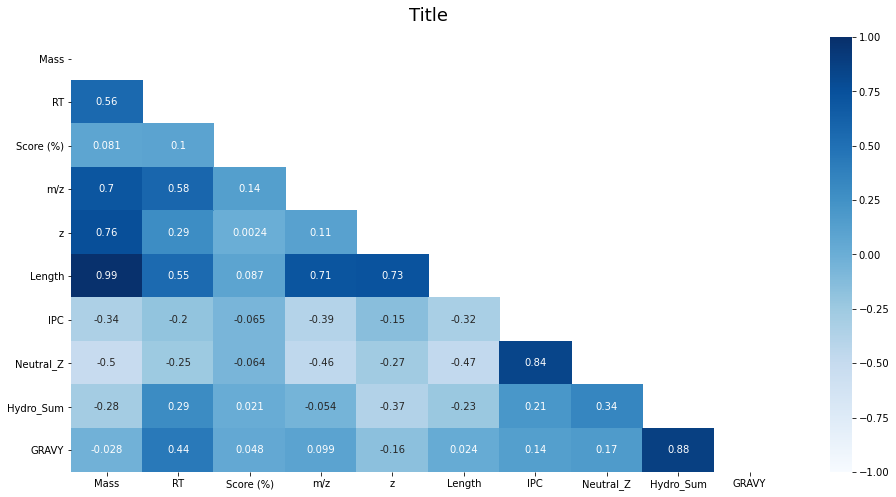

In [35]:
ApplePie(Tryp1_50,apples=apples,save_name="T150_Heat")

In [39]:
def WeddingCake(df,x,y,z,dpi=300,s=12,alpha=0.3,edgecolor='k',color="blue",my_viewx=20,my_viewy=50,
               xlabel="Parameter xlabel",ylabel="Parameter ylabel",zlabel="Parameter zlabel",fmt='png',
               figx=10,figy=10,xmin=0,xmax=1000,ymin=0,ymax=1000,zmin=0,zmax=1000):
    fig = plt.figure(figsize=(figx,figy),dpi=dpi)
    ax = fig.gca(projection='3d')
    X = df[x]
    Y = df[y]
    Z = df[z]
    ax.scatter(X,Y,Z,color=color,s=s,alpha=alpha,edgecolor=edgecolor)
    ax.view_init(my_viewx,my_viewy)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.xaxis._axinfo["grid"].update({"linewidth":1, "color" : "grey"})
    ax.yaxis._axinfo["grid"].update({"linewidth":1, "color" : "grey"})
    ax.zaxis._axinfo["grid"]['color'] = "k"
    ax.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax.set_ylim3d(ymin,ymax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_zlim3d(zmin,zmax)
    FigTitle=input('Figure Title:')
    plt.savefig(FigTitle,format=fmt,dpi=dpi,bbox_inches="tight")
    plt.show

Figure Title:cheese


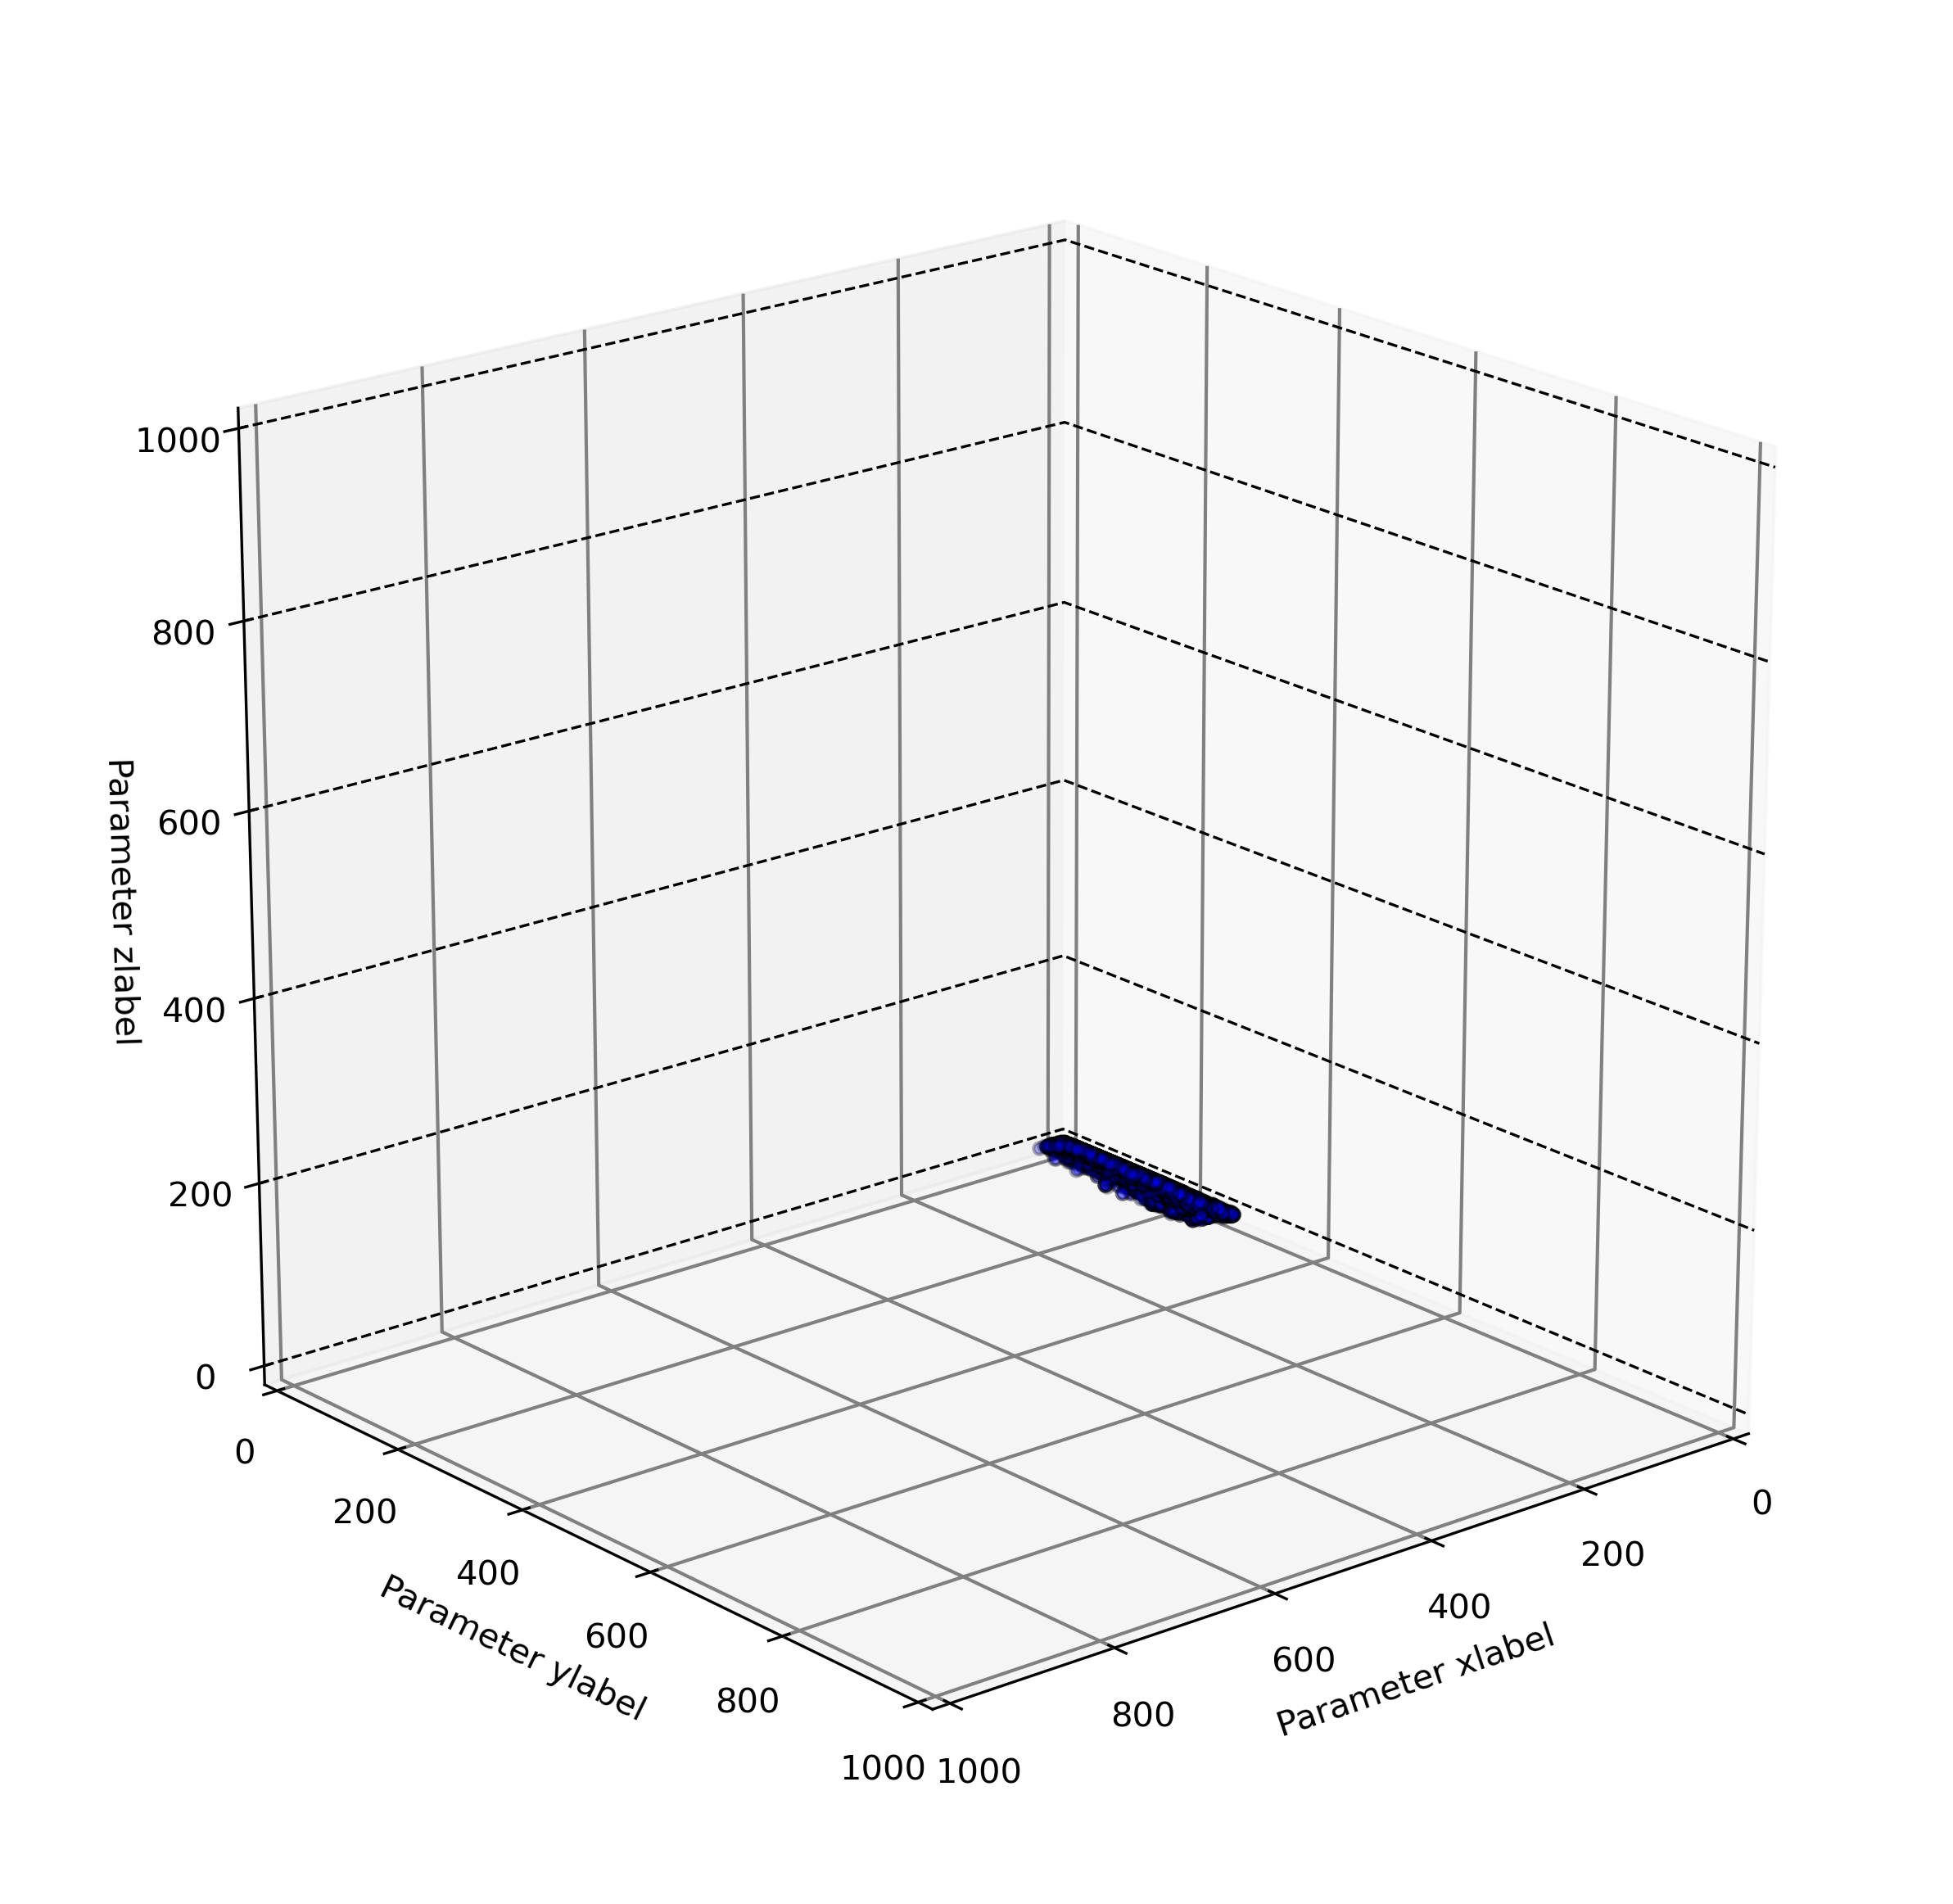

In [40]:
WeddingCake(T1_50_pep,"Length","RT","z")

In [ ]:
def Cake(df,x,y,dpi=600,s=25,alpha=0.25,edgecolor='k',color="blue",fmt='eps',labsize=18,
               figx=10,figy=10,xmin=0,xmax=1000,ymin=0,ymax=1000,xlabel="xlabel parameter",ylabel="ylabel parameter",
        loc=2,pad=1,borderpad=1,frameon=True, show=False):
    fig, ax = plt.subplots(1,1,figsize=(figx,figy),dpi=dpi)
    X = df[x]
    Y = df[y]
    plt.scatter(X,Y,color=color,s=s, alpha=alpha,edgecolor=edgecolor)
    plt.xlabel(xlabel, fontsize=labsize)
    plt.ylabel(ylabel, fontsize=labsize)
    corr, _ = pearsonr(X, Y)
    # loc works the same as it does with figures (though best doesn't work)
    # pad=5 will increase the size of padding between the border and text
    # borderpad=5 will increase the distance between the border and the axes
    # frameon=False will remove the box around the text
    anchored_text = AnchoredText('Pearsons correlation: r = %.3f' % corr, loc=loc,pad=pad,borderpad=borderpad,frameon=frameon)
    ax.add_artist(anchored_text)
    FigTitle=input('Figure Title:')
    plt.savefig(FigTitle,format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
Cake(T1_50_pep,"Length","z",color="Green")

#### 4-way (IPC,Mass,Charge,Length)

In [41]:
def CakePop(df,x,xi,y,yi, figx=10,figy=10,dpi=600,font_scale=1.5,figstyle="white",xlabel="xlabel",ylabel="ylabel",labsize=18,
           cmapx=-0.3,cmapy=0.0,sizex=10,sizey=200,loc='upper left',pad=1,borderpad=1,frameon=True):
    sns.set(font_scale=font_scale)
    cake=sns.set_style(figstyle)
    cmap = sns.cubehelix_palette(start=cmapx, rot=cmapy, as_cmap=True)
    X = df[x]
    Y = df[y]
    cake=sns.relplot(data=df,
    x=X, y=Y,
    hue=xi, size=yi,
    palette=cmap, sizes=(sizex, sizey))
    ax = cake.axes[0,0]
    ####
    corr, _ = pearsonr(X, Y)
    anchored_text = AnchoredText('Pearsons correlation: r = %.3f' % corr, loc=loc, prop=dict(size=labsize*0.5),pad=pad,borderpad=borderpad,frameon=frameon)
    ax.add_artist(anchored_text)
    ####
    plt.xlabel(xlabel, fontsize=labsize)
    plt.ylabel(ylabel, fontsize=labsize)
    FigTitle=input('Figure Title:')
    plt.savefig(FigTitle,format=fmt,dpi=dpi,bbox_inches="tight")
    plt.show(cake)

Figure Title:cheesecake


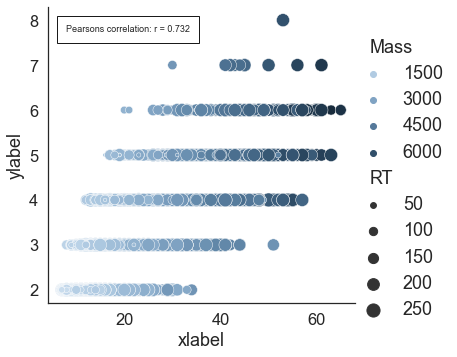

In [42]:
CakePop(T1_50_pep,"Length","Mass","z","RT")

### Figures for 18hr Trypsin Peptides

#### Correlation Matrix

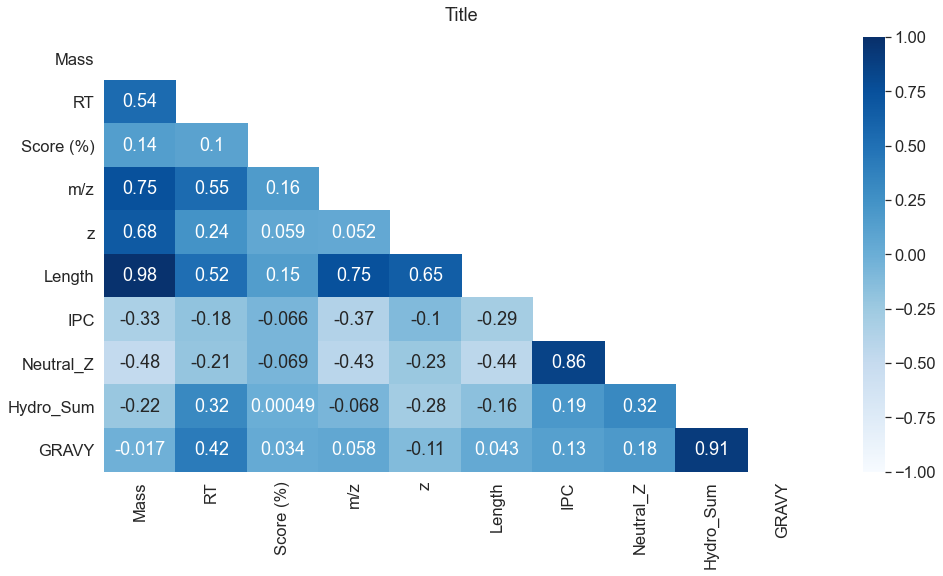

In [43]:
ApplePie(T18_50_pep,apples=apples,save_name="T1850_Heat")

Figure Title:dsfsdf


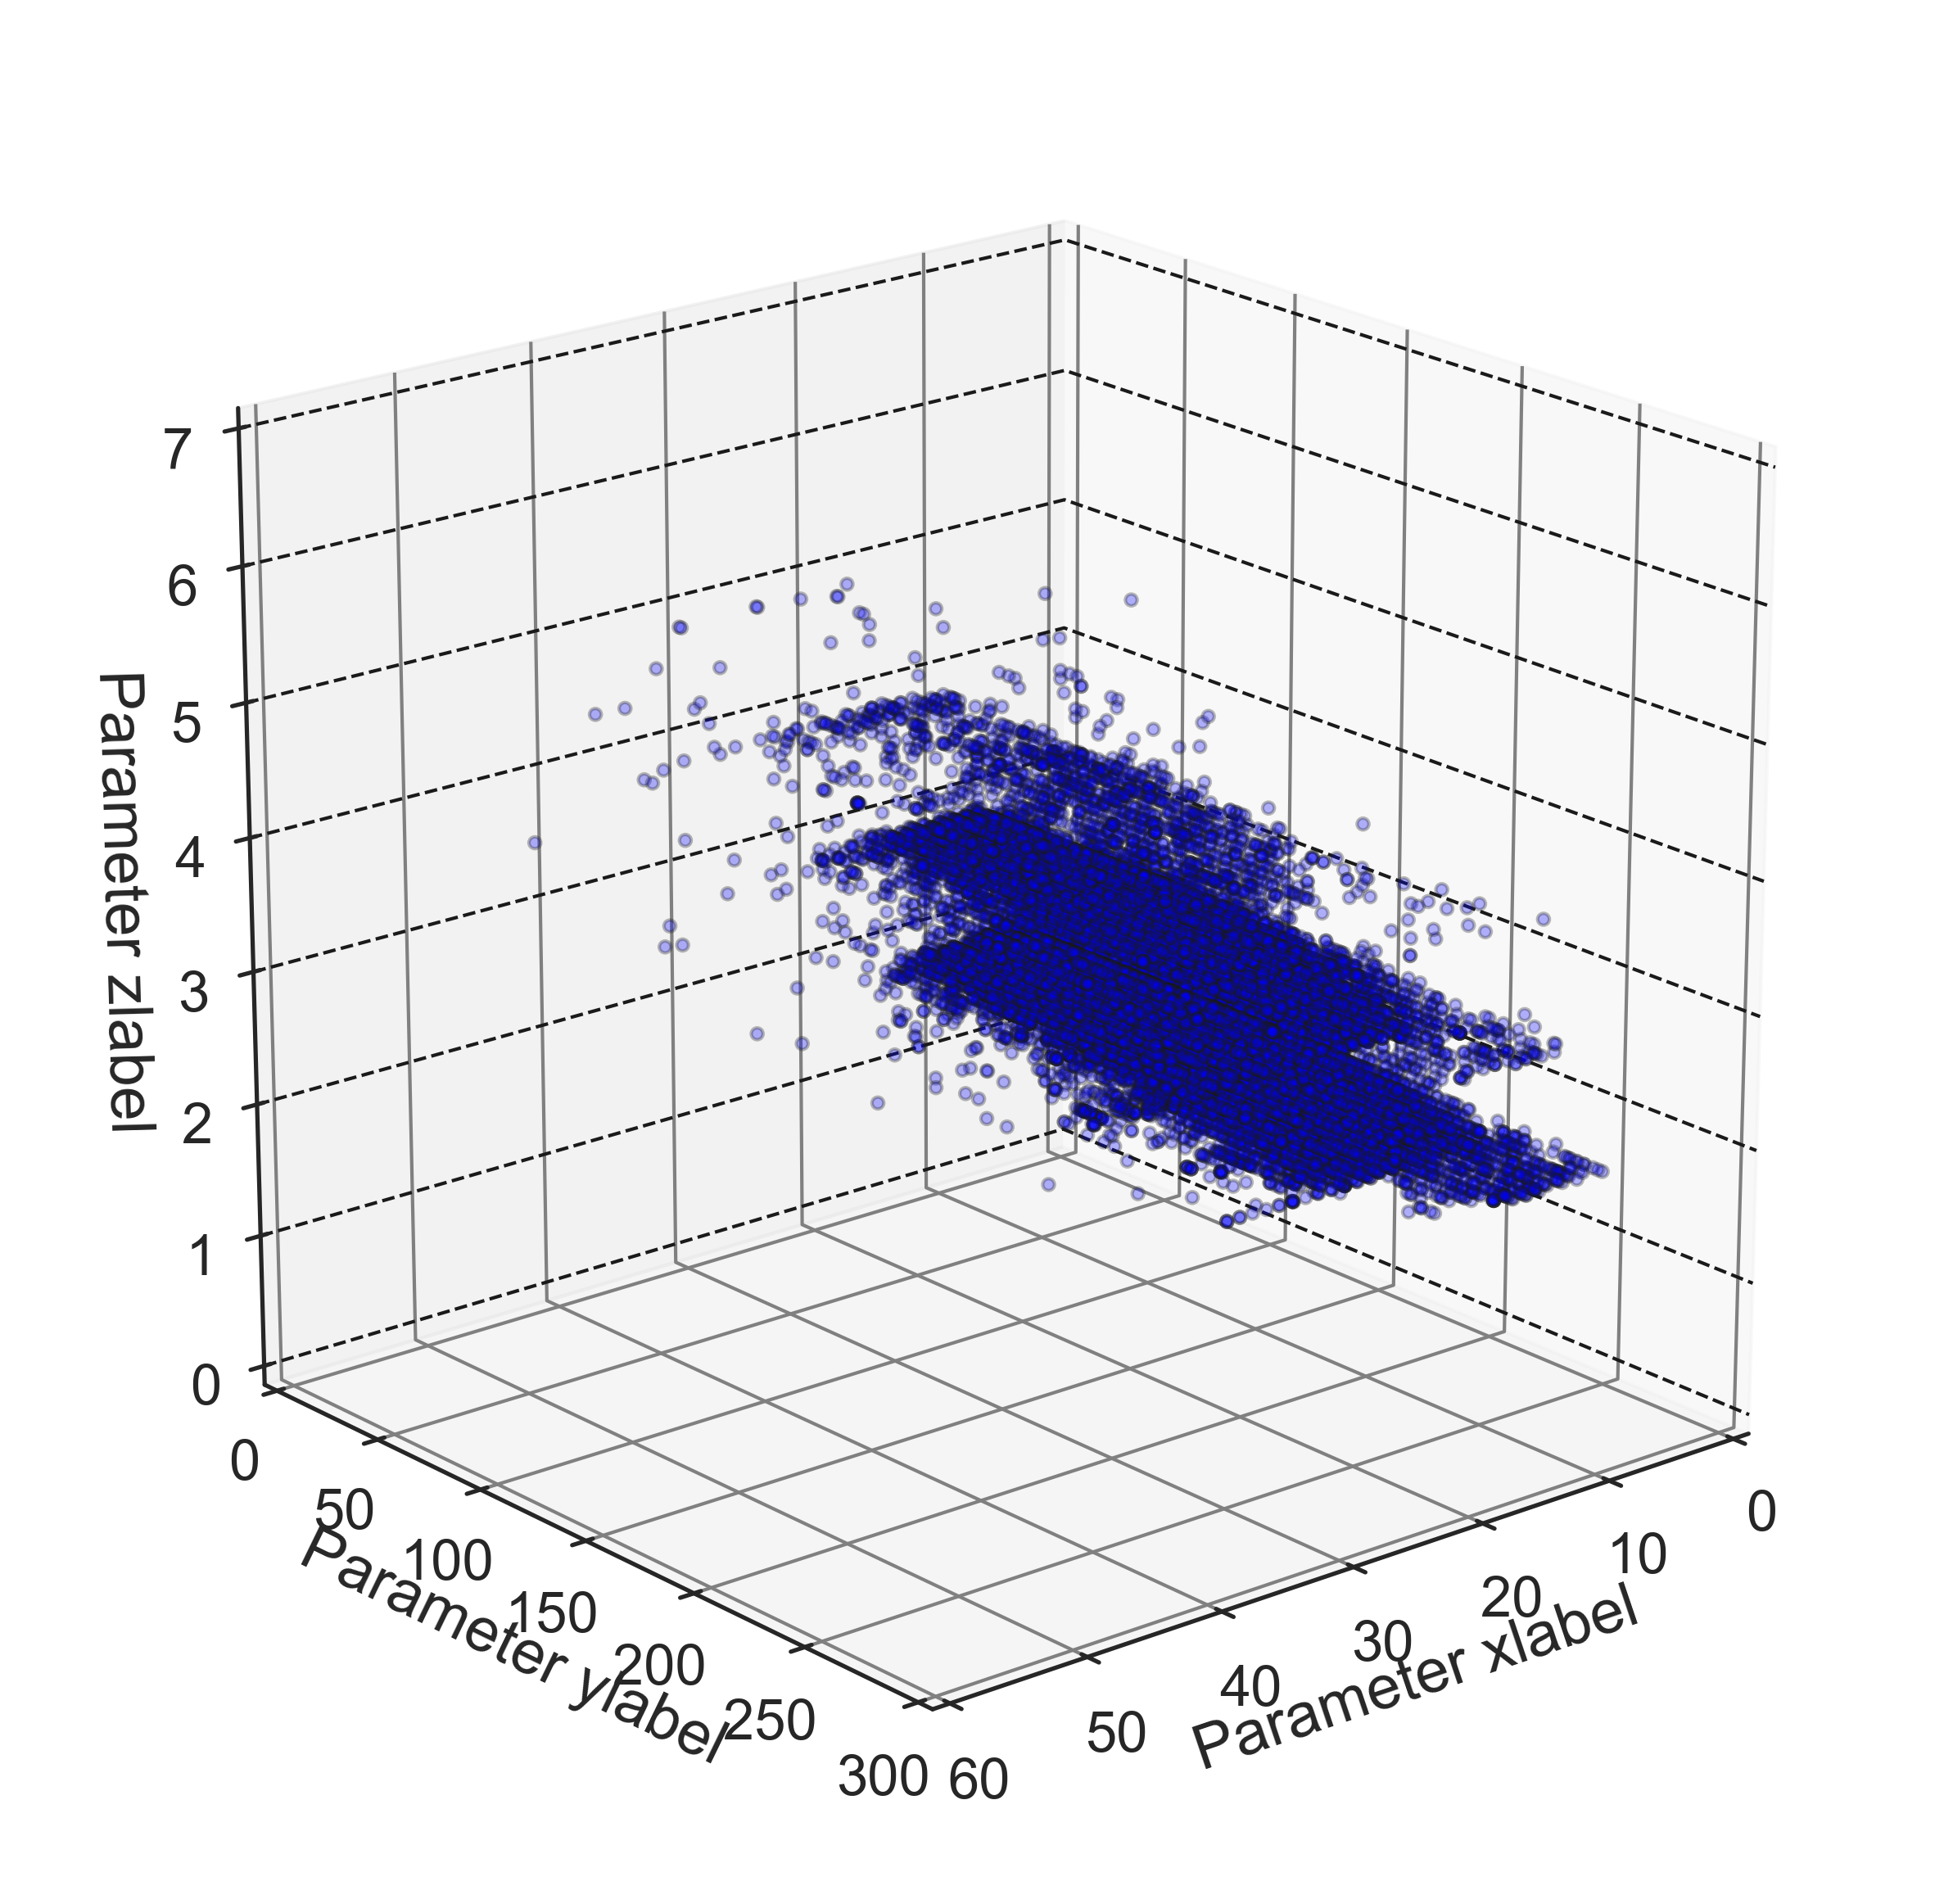

In [44]:
WeddingCake(T18_50_pep,"Length","RT","z", xmin=0,xmax=60,ymin=0,ymax=300,zmin=0,zmax=7)

In [45]:
Cake(T18_50_pep,"Length","z")

NameError: name 'Cake' is not defined

#### 4-way (IPC,Mass,Charge,Length)

Figure Title:fgfw


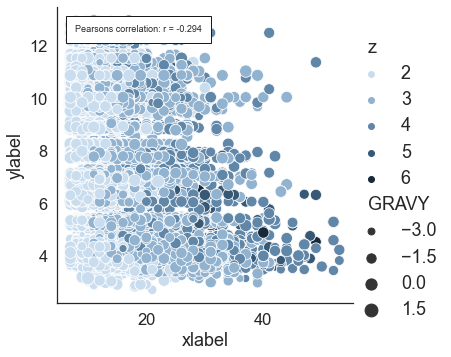

In [46]:
CakePop(T18_50_pep,"Length","z","IPC","GRAVY")

## <b> AspN Peptide Analyses </b>

In [ ]:
# Selection of 1hr Trypsin 
x="AspN"
y="1hr"
area1="Area AspN_1hr_1:50_Rep1"
area2="Area AspN_1hr_1:50_Rep2"
area3=None
acid=['A', 'R', 'N','D', 'C', 'Q','E', 'G', 'H',
             'I', 'L', 'K', 'F', 'P',
             'S', 'T', 'W','Y', 'V']
excel_name="AspN1hr_50"
AspN, AspN1_50=Butcher(og_pep,ident1=x,ident2=y,t_id1=area1,t_id2=area2,t_id3=area3,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Marinate(AspN1_50,"Peptide",IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

#Split Replicates
AspN1_50_Rep1=AspN1_50.loc[(AspN1_50['Area AspN_1hr_1:50_Rep1'] > 0)]
AspN1_50_Rep2=AspN1_50.loc[(AspN1_50['Area AspN_1hr_1:50_Rep2'] > 0)]

# #Copy Dataframe for Cross-Protein Analysis

A1_50_pep=AspN1_50.copy()


###AspN_18hr_50
# Selection of 1hr Trypsin 
x="AspN"
y="18hr"
area1="Area AspN_18hr_1:50_Rep1"
area2="Area AspN_18hr_1:50_Rep2"
area3=None
acid=['A', 'R', 'N','D', 'C', 'Q','E', 'G', 'H',
             'I', 'L', 'K', 'F', 'P',
             'S', 'T', 'W','Y', 'V']
excel_name="AspN1hr_50"
AspN, AspN18_50=Butcher(og_pep,ident1=x,ident2=y,t_id1=area1,t_id2=area2,t_id3=area3,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Marinate(AspN18_50,"Peptide",IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

#Split Replicates
AspN18_50_Rep1=AspN18_50.loc[(AspN18_50['Area AspN_18hr_1:50_Rep1'] > 0)]
AspN18_50_Rep2=AspN18_50.loc[(AspN18_50['Area AspN_18hr_1:50_Rep2'] > 0)]

# #Copy Dataframe for Cross-Protein Analysis

A18_50_pep=AspN18_50.copy()

In [ ]:
chicken,pot, pie = Wishbone(AspN1_50, "Gene")

In [ ]:
silver_A1=Sampler(AspN1_50,toothpicks=toothpicks,samples=samples)

In [ ]:
chicken,pot, pie = Wishbone(AspN18_50, "Gene")

In [ ]:
silver_A18=Sampler(AspN18_50,toothpicks=toothpicks,samples=samples)

In [ ]:
x,y,z=Sweet_N_Sour(AspN1_50.Peptide,AspN18_50.Peptide)

### ICE LOGO for AspN

In [ ]:
A1_ice=Peptide_ICEmaker(peptide=AspN1_50["Peptide"],excel_name="AspN_1hr")

In [ ]:
A18_ice=Peptide_ICEmaker(peptide=AspN18_50["Peptide"],excel_name="AspN_1hr")

### Figures for AspN 1hr

#### Correlation Matrix

In [ ]:
ApplePie(A1_50_pep,apples,cmap="Greens")

In [ ]:
WeddingCake(A1_50_pep,"Length","IPC","GRAVY",xmin=10,ymax=100,xmax=70,zmax=3,color='green')

In [ ]:
Cake(A1_50_pep,"GRAVY","Mass", color="green",xlabel="GRAVY Score(Hydrophobicity)")

#### 4-way (IPC,Mass,Charge,Length)

In [ ]:
CakePop(A1_50_pep,"GRAVY","Mass","z","Length")

### Figures for AspN 18hr

#### Correlation Matrix

In [ ]:
ApplePie(A18_50_pep,apples,cmap="Greens")

In [ ]:
WeddingCake(A18_50_pep,"GRAVY","Mass","IPC")

In [ ]:
plt.scatter(X,Z,color='green',s=24, alpha=0.3)
plt.xlabel('Peptide Length')
plt.ylabel('Peptide Charge')
#plt.savefig('AspN1_50_sctatter_charge_RT',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
from scipy.stats import pearsonr
corr, _ = pearsonr(X, Z)
print('Pearsons correlation: %.3f' % corr)

In [ ]:
plt.scatter(X,Y,color='green',s=24, alpha=0.3)
plt.xlabel('Peptide Length')
plt.ylabel('m/z')
#plt.savefig('AspN1_50_sctatter_charge_RT',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:

corr, _ = pearsonr(X, Y)
print('Pearsons correlation: %.3f' % corr)

In [ ]:
plt.scatter(Y,Z,color='green',s=24, alpha=0.3)
plt.xlabel('m/z')
plt.ylabel('Peptide Charge')
#plt.savefig('AspN1_50_sctatter_charge_RT',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:

corr, _ = pearsonr(Z, Y)
print('Pearsons correlation: %.3f' % corr)

#### 4-way (IPC,Mass,Charge,Length)

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=300)
sns.set(font_scale = 1.5)
sns.set_style("white")
cmap = sns.cubehelix_palette(start=-.1, rot=-.5, as_cmap=True)
sns.relplot(
    data=A18_50_pep,
    x="Mass", y='IPC',
    hue="z", size="Length",
    palette=cmap, sizes=(10, 200),ax=ax
)
plt.savefig('AspN18_50_hydro_4way',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
Z=A18_50_pep['IPC']
Y=A18_50_pep['Mass']
corr, _ = pearsonr(Z, Y)
print('Pearsons correlation: %.3f' % corr)

## <b>GluC Peptide Analyses </b>

In [ ]:
y='GluC'
x=y
GluC=og_pep.loc[:, og_pep.columns.str.contains(x)]
#GluC.to_excel('GluC_peptide.xlsx')

###GluC_1hr_50
y='1hr'
x=y
GluC1_50=GluC.loc[:, GluC.columns.str.contains(x)]
GluC1_50 = pd.concat([og_mz, GluC1_50], axis=1)
GluC1_50=GluC1_50.loc[(GluC1_50['Area GluC_1hr_1:50_Rep1'] > 0) | (GluC1_50['Area GluC_1hr_1:50_Rep2'] > 0)]

L=["E"]
GluC1_50["Peptide"]= GluC1_50["Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(L)) else x)
GluC1_50["Peptide"] =GluC1_50["Peptide"].str.replace('\W+','')
GluC1_50["Peptide"] = GluC1_50["Peptide"].str.replace('\d+', '')
GluC1_50['IPC'] = GluC1_50['Peptide'].apply(isoelectric_point)
GluC1_50['Hydro_Sum'] = GluC1_50['Peptide'].apply(hydrophobicity_score)
GluC1_50['Hydro_Sum_Norm']=GluC1_50['Hydro_Sum'] / GluC1_50['Length']
GluC1_50['Neutral_Z'] = GluC1_50['Peptide'].apply(overall_charge)


GluC1_50_Rep1=GluC1_50.loc[(GluC1_50['Area GluC_1hr_1:50_Rep1'] > 0)]
GluC1_50_Rep2=GluC1_50.loc[(GluC1_50['Area GluC_1hr_1:50_Rep2'] > 0)]

G1_50_pep=GluC1_50.copy()


###GluC_18hr_50
y='18hr'
x=y
GluC18_50=GluC.loc[:, GluC.columns.str.contains(x)]
GluC18_50 = pd.concat([og_mz, GluC18_50], axis=1)
GluC18_50=GluC18_50.loc[(GluC18_50['Area GluC_18hr_1:50_Rep1'] > 0) | (GluC18_50['Area GluC_18hr_1:50_Rep2'] > 0)]

L=["E"]
GluC18_50["Peptide"]= GluC18_50["Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(L)) else x)
GluC18_50["Peptide"] =GluC18_50["Peptide"].str.replace('\W+','')
GluC18_50["Peptide"] = GluC18_50["Peptide"].str.replace('\d+', '')
GluC18_50['IPC'] = GluC18_50['Peptide'].apply(isoelectric_point)
GluC18_50['Hydro_Sum'] = GluC18_50['Peptide'].apply(hydrophobicity_score)
GluC18_50['Hydro_Sum_Norm']=GluC18_50['Hydro_Sum'] / GluC18_50['Length']
GluC18_50['Neutral_Z'] = GluC18_50['Peptide'].apply(overall_charge)


GluC18_50_Rep1=GluC18_50.loc[(GluC18_50['Area GluC_18hr_1:50_Rep1'] > 0)]
GluC18_50_Rep2=GluC18_50.loc[(GluC18_50['Area GluC_18hr_1:50_Rep2'] > 0)]

G18_50_pep=GluC18_50.copy()

In [ ]:
GluC1_50.head()

In [ ]:
GluC1_50_Rep1.describe()

In [ ]:
GluC1_50_Rep2.describe()

In [ ]:
x=GluC1_50['Gene'].value_counts()
x2=pd.DataFrame(x, columns=['Gene'])
x3 = x2.loc[(x2['Gene']) > 1]
x
x4=len(x3)/len(x2)*100 
print('Ratio of Proteins with >2 Peptide Identified is: %.3f' % x4)

In [ ]:
G_1_50_charge = GluC1_50['z']
G_1_50_length = GluC1_50['Length']
G_1_50_mass = GluC1_50['Mass']
G_1_50_hydro =GluC1_50['IPC']

In [ ]:
GluC18_50.describe()

In [ ]:
GluC18_50_Rep1.head()

In [ ]:
GluC18_50_Rep2.describe()

In [ ]:
x=GluC18_50['Gene'].value_counts()
x2=pd.DataFrame(x, columns=['Gene'])
x3 = x2.loc[(x2['Gene']) > 1]
x3
x4=len(x3)/len(x2)*100 
print('Ratio of Proteins with >2 Peptide Identified is: %.3f' % x4)

In [ ]:
G_18_50_charge = GluC18_50['z']
G_18_50_length = GluC18_50['Length']
G_18_50_mass = GluC18_50['Mass']
G_18_50_hydro =GluC18_50['IPC']

In [ ]:
common=len(list(set(GluC18_50.Peptide) & set(GluC1_50.Peptide)))
common

In [ ]:
unique=len(list(set(GluC18_50.Peptide) ^ set(GluC1_50.Peptide)))
unique

In [ ]:
Ratio=(unique/(common+unique))*100
Ratio

### ICE LOGO for GluC

In [ ]:
GluC1_50_pep = GluC1_50['Peptide']
GluC1_50_pep =GluC1_50_pep.str.replace('\W+','')
GluC1_50_pep = GluC1_50_pep.str.replace('\d+', '')
GluC1_50_pep = GluC1_50_pep.str.slice(0,5)
GluC1_50_pep.to_excel('GluC_IceLogo_1hr_50.xlsx')
GluC1_50_pep.head()

In [ ]:
GluC18_50_pep = GluC18_50['Peptide']
GluC18_50_pep =GluC18_50_pep.str.replace('\W+','')
GluC18_50_pep = GluC18_50_pep.str.replace('\d+', '')
GluC18_50_pep = GluC18_50_pep.str.slice(0,5)
GluC18_50_pep.to_excel('GluC_IceLogo_18hr_50.xlsx')
GluC18_50_pep

### Figures for GluC 1hr

#### Correlation Matrix

In [ ]:
og_corr=G1_50_pep[['Mass','RT','Score (%)','m/z','z','Length','IPC','Neutral_Z', 'Hydro_Sum','Hydro_Sum_Norm']]

In [ ]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(og_corr.corr(), dtype=np.bool))
heatmap = sns.heatmap(og_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='Reds')
heatmap.set_title('Correlation Heatmap of Peptide Characteristics', fontdict={'fontsize':18}, pad=16);
plt.savefig('Correlation_G1',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
#3D scatter plot for peptide analyses
fig = plt.figure(figsize=(8,8), dpi=300)
ax = fig.gca(projection='3d')
X=G1_50_pep['Length']
Y=G1_50_pep['m/z']
Z=G1_50_pep['z']
ax.scatter(X, Y, Z,color='red',s=12,alpha=0.3, edgecolor='k')
ax.view_init(20, 50)
ax.set_xlabel('Peptide Mass')
ax.set_ylabel('m/z')
ax.set_zlabel('Retention Time (mins)')
ax.xaxis._axinfo["grid"].update({"linewidth":1, "color" : "grey"})
ax.yaxis._axinfo["grid"].update({"linewidth":1, "color" : "grey"})
ax.zaxis._axinfo["grid"]['color'] = "k"
ax.zaxis._axinfo["grid"]['linestyle'] = "--"
#ax.set_ylim3d(0, 300)
#ax.set_xlim3d(0,6000)
#ax.set_zlim3d(0,250)

In [ ]:
plt.scatter(X,Z,color='red',s=24, alpha=0.3)
plt.xlabel('Peptide Length')
plt.ylabel('Peptide Charge')
#plt.savefig('AspN1_50_sctatter_charge_RT',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
corr, _ = pearsonr(X, Z)
print('Pearsons correlation: %.3f' % corr)

In [ ]:
plt.scatter(X,Y,color='red',s=24, alpha=0.3)
plt.xlabel('Peptide Length')
plt.ylabel('m/z')
#plt.savefig('AspN1_50_sctatter_charge_RT',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
corr, _ = pearsonr(X, Y)
print('Pearsons correlation: %.3f' % corr)

In [ ]:
plt.scatter(Y,Z,color='red',s=24, alpha=0.3)
plt.xlabel('m/z')
plt.ylabel('Peptide Charge')
#plt.savefig('AspN1_50_sctatter_charge_RT',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
corr, _ = pearsonr(Z, Y)
print('Pearsons correlation: %.3f' % corr)

#### 4-way (IPC,Mass,Charge,Length)

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=300)
sns.set(font_scale = 1.5)
sns.set_style("white")
cmap = sns.cubehelix_palette(start=-.3, rot=.6, as_cmap=True)
sns.relplot(
    data=G1_50_pep,
    x="Mass", y='IPC',
    hue="z", size="Length",
    palette=cmap, sizes=(10, 200),ax=ax
)
plt.savefig('GluC1_50_hydro_4way',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
Z=G1_50_pep['IPC']
Y=G1_50_pep['Mass']
corr, _ = pearsonr(Z, Y)
print('Pearsons correlation: %.3f' % corr)

In [ ]:
Z=G1_50_pep['Hydro_Sum_Norm']
Y=G1_50_pep['IPC']
corr, _ = pearsonr(Z, Y)
print('Pearsons correlation: %.3f' % corr)

In [ ]:
Z=G1_50_pep['Hydro_Sum']
Y=G1_50_pep['IPC']
corr, _ = pearsonr(Z, Y)
print('Pearsons correlation: %.3f' % corr)

### Figures for GluC 18hr

#### Correlation Matrix

In [ ]:
og_corr=G18_50_pep[['Mass','RT','Score (%)','m/z','z','Length','IPC','Neutral_Z', 'Hydro_Sum','Hydro_Sum_Norm']]

In [ ]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(og_corr.corr(), dtype=np.bool))
heatmap = sns.heatmap(og_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='Reds')
heatmap.set_title('Correlation Heatmap of Peptide Characteristics', fontdict={'fontsize':18}, pad=16);
plt.savefig('Correlation_G18',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
#3D scatter plot for peptide analyses
fig = plt.figure(figsize=(8,8), dpi=300)
ax = fig.gca(projection='3d')
X=G18_50_pep['Length']
Y=G18_50_pep['m/z']
Z=G18_50_pep['z']
ax.scatter(X, Y, Z,color='red',s=12,alpha=0.3, edgecolor='k')
ax.view_init(20, 50)
ax.set_xlabel('Peptide Mass')
ax.set_ylabel('m/z')
ax.set_zlabel('Retention Time (mins)')
ax.xaxis._axinfo["grid"].update({"linewidth":1, "color" : "grey"})
ax.yaxis._axinfo["grid"].update({"linewidth":1, "color" : "grey"})
ax.zaxis._axinfo["grid"]['color'] = "k"
ax.zaxis._axinfo["grid"]['linestyle'] = "--"
#ax.set_ylim3d(0, 300)
#ax.set_xlim3d(0,6000)
#ax.set_zlim3d(0,250)

In [ ]:
sns.jointplot(data=G18_50_pep,x="Length",y="RT",kind='kde')

In [ ]:
plt.scatter(X,Z,color='red',s=24, alpha=0.3)
plt.xlabel('Peptide Length')
plt.ylabel('Peptide Charge')
#plt.savefig('AspN1_50_sctatter_charge_RT',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
corr, _ = pearsonr(X, Z)
print('Pearsons correlation: %.3f' % corr)

In [ ]:
plt.scatter(X,Y,color='red',s=24, alpha=0.3)
plt.xlabel('Peptide Length')
plt.ylabel('m/z')
#plt.savefig('AspN1_50_sctatter_charge_RT',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
corr, _ = pearsonr(X, Y)
print('Pearsons correlation: %.3f' % corr)

In [ ]:
plt.scatter(Y,Z,color='red',s=24, alpha=0.3)
plt.xlabel('m/z')
plt.ylabel('Peptide Charge')
#plt.savefig('AspN1_50_sctatter_charge_RT',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
corr, _ = pearsonr(Z, Y)
print('Pearsons correlation: %.3f' % corr)

#### 4-way (IPC,Mass,Charge,Length)

In [ ]:
fig = plt.figure(figsize=(20,20), dpi=300)
sns.set(font_scale = 1.5)
sns.set_style("white")
cmap = sns.cubehelix_palette(start=-.3, rot=.6, as_cmap=True)
sns.relplot(
    data=G18_50_pep,
    x="Mass", y='IPC',
    hue="z", size="Length",
    palette=cmap, sizes=(10, 200),ax=ax
)
plt.savefig('GluC18_50_hydro_4way',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
Z=G18_50_pep['IPC']
Y=G18_50_pep['Mass']
corr, _ = pearsonr(Z, Y)
print('Pearsons correlation: %.3f' % corr)

# Mixed Peptide Figures

In [ ]:
### Colour Selection 
colors = ["#2A3694","#4C72B1","#9F0A2F","#FE0000","#0F5F31","#119347"]
color_map=sns.set_palette(sns.color_palette(colors,6))

## KDE and Box Plots

#### Length

In [ ]:
#Length of Peptides
x=[T_18_50_length,T_1_50_length,A_18_50_length,A_1_50_length,G_18_50_length,G_1_50_length]
length=[]
length=pd.concat([i for i in x], axis=1)
length.columns = ['Trypsin_18hrs', 'Trypsin_1hrs','AspN_18hrs','AspN_1hrs','GluC_18hrs','GluC_1hrs']
length

In [ ]:
df1 = length.stack().reset_index()
df1.columns = ['Null','Digest','Length']
df1.drop(['Null'], axis=1, inplace=True)
df1

In [ ]:
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Length", hue="Digest",
    kind="kde", height=15,log_scale=(0,2),color=color_map
    
)
plt.xticks([10,20,30,40,50,60,70])
plt.xlabel('Length', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
g.savefig("Length.eps")

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=length,height=10, kind='box',color=color_map)
plt.savefig("Length_boxen.eps", dpi=dpi)

#### Charge

In [ ]:
#Charge of Peptides
xx=[T_18_50_charge,T_1_50_charge,A_18_50_charge,A_1_50_charge,G_18_50_charge,G_1_50_charge]
charge=[]
charge=pd.concat([i for i in xx], axis=1)
charge.columns = ['Trypsin_18hrs', 'Trypsin_1hrs','AspN_18hrs','AspN_1hrs','GluC_18hrs','GluC_1hrs']
charge

In [ ]:
df1 = charge.stack().reset_index()
df1.columns = ['Null','Digest','Charge']
df1.drop(['Null'], axis=1, inplace=True)
df1

In [ ]:
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Charge", hue="Digest",
    kind="kde", height=15,log_scale=(0,2),palette=color_map
    
)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel('Positive Charge State', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
g.savefig("Charge.eps")

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=charge,height=10, kind='box')
plt.savefig("Charge_boxen.eps", dpi=dpi)

#### Mass

In [ ]:
#Charge of Peptides
xxx=[T_18_50_mass,T_1_50_mass,A_18_50_mass,A_1_50_mass,G_18_50_mass,G_1_50_mass]
mass=[]
mass=pd.concat([i for i in xxx], axis=1)
mass.columns = ['Trypsin_18hrs', 'Trypsin_1hrs','AspN_18hrs','AspN_1hrs','GluC_18hrs','GluC_1hrs']
mass

In [ ]:
df1 = mass.stack().reset_index()
df1.columns = ['Null','Digest','Mass']
df1.drop(['Null'], axis=1, inplace=True)
df1

In [ ]:
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Mass", hue="Digest",
    kind="kde", height=15,log_scale=(0,2),
    
)
# plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel('Mass(kDa)', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
g.savefig("Mass.eps")

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=mass,height=10, kind='box')
plt.title("Mass of Peptides")
plt.savefig("Mass_boxen.eps", dpi=dpi)

#### Hydrophobicity

In [ ]:
#Hydrophobicity of Peptides
xx=[T_18_50_hydro,T_1_50_hydro,A_18_50_hydro,A_1_50_hydro,G_18_50_hydro,G_1_50_hydro]
hydro=[]
hydro=pd.concat([i for i in xx], axis=1)
hydro.columns = ['Tryp_18_50', 'Tryp_1_50','AspN_18_50','AspN_1_50','GluC_18_50','GluC_1_50']
hydro

In [ ]:
df1 = hydro.stack().reset_index()
df1.columns = ['Null','Digest','Hydro_Score']
df1.drop(['Null'], axis=1, inplace=True)
df1

##### Hydro_Score Statistics

In [ ]:
mod = ols('Hydro_Score~Digest',data=df1).fit()
hydro_anova=sm.stats.anova_lm(mod) 
print(hydro_anova)
print(mod.summary())

In [ ]:
Hydro_ANOVA=sm.stats.multicomp.pairwise_tukeyhsd(df1["Hydro_Score"],df1["Digest"],alpha=0.05)
Hydro_ANOVA

In [ ]:
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Hydro_Score", hue="Digest",
    kind="kde", height=15,log_scale=(0,0),
    
)
plt.xlabel('Hydrophobicity', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
g.savefig("Hydro.eps")

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=hydro,height=10, kind='box')
# plt.title("Hydo of Peptides")
plt.savefig("HydroScore_Box.eps", dpi=dpi)

In [ ]:
T_1_50_RT =Tryp1_50['RT']
T_18_50_RT =Tryp18_50['RT']
A_1_50_RT =AspN1_50['RT']
A_18_50_RT =AspN18_50['RT']
G_1_50_RT =GluC1_50['RT']
G_18_50_RT =GluC18_50['RT']
xx=[T_18_50_RT,T_1_50_RT,A_18_50_RT,A_1_50_RT,G_18_50_RT,G_1_50_RT]
RT=[]
RT=pd.concat([i for i in xx], axis=1)
RT.columns = ['Tryp_18_50', 'Tryp_1_50','AspN_18_50','AspN_1_50','GluC_18_50','GluC_1_50']
RT

In [ ]:
df2 = RT.stack().reset_index()
df2.columns = ['Null','Digest','RT']
df2.drop(['Null'], axis=1, inplace=True)
df2

In [ ]:
df3 = pd.concat([df1,df2],axis=1)
df3.columns = ['Null','Hydro','Digest', 'RT']
df3.drop(['Null'], axis=1, inplace=True)
df3

## Grouped Peptide Analyses

In [ ]:
og_pep.groupby(['Protein Accession']).size().reset_index(name='counts')

### Grouping by Protein Identification (# of Peptides per Protein)

In [ ]:
grouping = ['Gene']

T18_Counts=Tryp18_50.groupby(grouping).size().reset_index(name='counts')
T1_Counts=Tryp1_50.groupby(grouping).size().reset_index(name='counts')
A18_Counts=AspN18_50.groupby(grouping).size().reset_index(name='counts')
A1_Counts=AspN1_50.groupby(grouping).size().reset_index(name='counts')
G18_Counts=GluC18_50.groupby(grouping).size().reset_index(name='counts')
G1_Counts=GluC1_50.groupby(grouping).size().reset_index(name='counts')
# counts=pd.concat([T18_Counts, T1_Counts,A18_Counts,A1_Counts,G18_Counts,G1_Counts],axis=1)
# counts.columns=['T18','T18_Counts','T1','T1_Counts','A18','A18_Counts','A1','A1_Counts','G18','G18_Counts','G1','G1_Counts']
# counts = counts.sort_values(by ='G1_Counts', ascending=False )
T18_Counts

### Trypsin 18 hours, Counting protiens with > or < 1 peptide IDs

In [ ]:
T18_grouped=Tryp18_50.groupby(['Gene'], as_index=False).mean()
T18_50_pep=pd.concat([T18_grouped,T18_Counts.counts],axis=1)
T18_x2 = T18_50_pep.loc[(T18_50_pep['counts']) > 1]
T18_x3 = T18_50_pep.loc[(T18_50_pep['counts']) == 1]
x4=(len(T18_x3)/len(T18_x2))*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(T18_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(T18_x3))
print("The Ratio is:")
print(x4)
T18_x2

### Trypsin 1 hour, Counting protiens with > or < 1 peptide IDs

In [ ]:
T1_grouped=Tryp1_50.groupby(['Gene'], as_index=False).mean()
T1_50_pep=pd.concat([T1_grouped,T1_Counts.counts],axis=1)
T1_x2 = T1_50_pep.loc[(T1_50_pep['counts']) > 1]
T1_x3 = T1_50_pep.loc[(T1_50_pep['counts']) == 1]
x4=len(T1_x3)/len(T1_x2)*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(T1_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(T1_x3))
print("The Ratio is:")
print(x4)

### AspN 18 hours, Counting protiens with > or < 1 peptide IDs

In [ ]:

df2=AspN18_50.groupby(['Gene'], as_index=False).mean()
s=pd.concat([df2,A18_Counts.counts],axis=1)
A18_x2 = s.loc[(s['counts']) > 1]
A18_x3 = s.loc[(s['counts']) == 1]
x4=len(A18_x3)/len(A18_x2)*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(A18_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(A18_x3))
print("The Ratio is:")
print(x4)

###  AspN 1 hours, Counting protiens with > or < 1 peptide IDs

In [ ]:

df2=AspN1_50.groupby(['Gene'], as_index=False).mean()
s=pd.concat([df2,A1_Counts.counts],axis=1)
A1_x2 = s.loc[(s['counts']) > 1]
A1_x3 = s.loc[(s['counts']) == 1]
x4=len(A1_x3)/len(A1_x2)*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(A1_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(A1_x3))
print("The Ratio is:")
print(x4)

### GluC 18 hours, Counting protiens with > or < 1 peptide IDs

In [ ]:

df2=GluC18_50.groupby(['Gene'], as_index=False).mean()
s=pd.concat([df2,G18_Counts.counts],axis=1)
G18_x2 = s.loc[(s['counts']) > 1]
G18_x3 = s.loc[(s['counts']) == 1]
x4=len(G18_x3)/len(G18_x2)*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(G18_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(G18_x3))
print("The Ratio is:")
print(x4)

### GluC 1 hours, Counting protiens with > or < 1 peptide IDs 

In [ ]:

df2=GluC1_50.groupby(['Gene'], as_index=False).mean()
s=pd.concat([df2,G1_Counts.counts],axis=1)
G1_x2 = s.loc[(s['counts']) > 1]
G1_x3 = s.loc[(s['counts']) == 1]
x4=len(G1_x3)/len(G1_x2)*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(G1_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(G1_x3))
print("The Ratio is:")
print(x4)

### Peptide per Protein Stacked Bar Graph

In [ ]:
df = pd.DataFrame(columns=["Group","Trypsin 18hrs","Trypsin 1hrs", "AspN 18hrs","AspN 1hrs",
                           "GluC 18hrs","GluC 1hrs",], 
                  data=[["= 1 Peptide",21.55,21.55,37.28,36.64,32.46,42.99],
                        ["> 1 Peptide",100-21.55,100-21.55,100-37.28,100-36.64,100-32.46,100-42.99],
])

In [ ]:
from matplotlib.colors import ListedColormap

df.set_index('Group')\
  .reindex(df.set_index('Group').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("PRGn", 10)), 
          figsize=(12,6))
# plt.savefig('Stacked_Peptide_per_Protein',format=fmt,dpi=dpi,bbox_inches="tight")

### IPC Hydrophobicity vs Peptide IDs/Protein

#### Proteins with >2 peptides detected

In [ ]:
xx=[T18_x2['IPC'],T1_x2['IPC'],A18_x2['IPC'],A1_x2['IPC'],G18_x2['IPC'],G1_x2['IPC']]
IPC=[]
IPC=pd.concat([i for i in xx], axis=1)
IPC.columns = ['Trypsin_18hrs', 'Trypsin_1hrs','AspN_18hrs','AspN_1hrs','GluC_18hrs','GluC_1hrs']
df1 = IPC.stack().reset_index()
df1.columns = ['Null','Digest','IPC']
df1.drop(['Null'], axis=1, inplace=True)


In [ ]:
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="IPC", hue="Digest",
    kind="kde", height=15,log_scale=(0,2),
    
)
plt.xlabel('Hydrophobicity(IPC))', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
plt.title('Hydrophobicity of Peptides for Proteins >2 Peptides',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.savefig('IPC_Kernel Density_over2peptides',format=fmt,dpi=dpi,bbox_inches="tight")

#### Proteins with <2 peptides detected

In [ ]:
xx=[T18_x3['IPC'],T1_x3['IPC'],A18_x3['IPC'],A1_x3['IPC'],G18_x3['IPC'],G1_x3['IPC']]
IPC=[]
IPC=pd.concat([i for i in xx], axis=1)
IPC.columns = ['Trypsin_18hrs', 'Trypsin_1hrs','AspN_18hrs','AspN_1hrs','GluC_18hrs','GluC_1hrs']
df1 = IPC.stack().reset_index()
df1.columns = ['Null','Digest','IPC']
df1.drop(['Null'], axis=1, inplace=True)


In [ ]:
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="IPC", hue="Digest",
    kind="kde", height=15,log_scale=(0,2),
    
)
plt.xlabel('Hydrophobicity(IPC))', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
plt.title('Hydrophobicity of Peptides for Proteins <2 Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.savefig('IPC_Kernel Density_under2peptides',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
# stop=stop

# Section 2: Analysis of Proteins Only

In [ ]:
og = pd.read_csv("proteins_1in50only.csv")
og[['Protein', 'Gene']] = og['Accession'].str.split('|', 1, expand=True)
og.head()

In [ ]:
og_info=og[['Protein ID','Protein', 'Gene','Avg. Mass','Score (%)','-10lgP','Coverage (%)','#Peptides']]

## Trypsin Protein Analyses

In [ ]:
Tryp=og.loc[:, og.columns.str.contains('Tryp')]
Tryp = pd.concat([og_info, Tryp], axis=1)
#Tryp.to_excel('AspN_50only.xlsx')
Tryp.describe()

In [ ]:
y='18hr'
x=y
Tryp18_50=Tryp.loc[:, Tryp.columns.str.contains(x)]
Tryp18_50 = pd.concat([og_info, Tryp18_50], axis=1)
Tryp18_50=Tryp18_50.loc[(Tryp18_50['#Spec Tryp_18hr_1:50_Rep1'] > 0) | (Tryp18_50['#Spec Trypsin_18hr_1:50_Rep2'] > 0)]
Tryp18_50_Rep1=Tryp18_50.loc[(Tryp18_50['#Spec Tryp_18hr_1:50_Rep1'] > 0)]
Tryp18_50_Rep2=Tryp18_50.loc[(Tryp18_50['#Spec Trypsin_18hr_1:50_Rep2'] > 0)]
#Tryp18_50.to_excel('Tryp_' + str(y)+'.xlsx')
Tryp18_50.describe()

In [ ]:
Tryp18_50_x=Tryp18_50
Tryp18_50_x['AvgCoverage'] = Tryp18_50_x[['Coverage (%) Tryp_18hr_1:50_Rep1','Coverage (%) Trypsin_18hr_1:50_Rep2']].mean(axis=1)
Tryp18_50_coverage=Tryp18_50.loc[(Tryp18_50['AvgCoverage']>0)]
T_18_50 = Tryp18_50_coverage['AvgCoverage']
Tryp18_50_coverage.describe()

In [ ]:
Tryp18_50.median()

In [ ]:
Tryp18_50_Rep1.describe()

In [ ]:
Tryp18_50_Rep2.describe()

In [ ]:
y='1hr'
x=y
Tryp1_50=Tryp.loc[:, Tryp.columns.str.contains(x)]
Tryp1_50 = pd.concat([og_info, Tryp1_50], axis=1)
Tryp1_50=Tryp1_50.loc[(Tryp1_50['#Spec Tryp_1hr_1:50_Rep1'] > 0) | (Tryp1_50['#Spec Tryp_1hr_1:50_Rep2'] > 0)]
Tryp1_50_Rep1=Tryp1_50.loc[(Tryp1_50['#Spec Tryp_1hr_1:50_Rep1'] > 0)]
Tryp1_50_Rep2=Tryp1_50.loc[(Tryp1_50['#Spec Tryp_1hr_1:50_Rep2'] > 0)]
#Tryp18_50.to_excel('Tryp_' + str(y)+'.xlsx')
Tryp1_50.describe()

In [ ]:
Tryp1_50_x=Tryp1_50
Tryp1_50_x['AvgCoverage'] = Tryp1_50_x[['Coverage (%) Tryp_1hr_1:50_Rep1','Coverage (%) Tryp_1hr_1:50_Rep2']].mean(axis=1)
Tryp1_50_coverage=Tryp1_50.loc[(Tryp1_50['AvgCoverage']>0)]
T_1_50 = Tryp1_50_coverage['AvgCoverage']
Tryp1_50_coverage.describe()

In [ ]:
Tryp1_50_Rep1.describe()

In [ ]:
Tryp1_50_Rep2.describe()

In [ ]:
Tryp1_50.median()

In [ ]:
common=len(list(set(Tryp18_50_coverage.Gene) & set(Tryp1_50_coverage.Gene)))
common

In [ ]:
unique=len(list(set(Tryp18_50_coverage.Gene) ^ set(Tryp1_50_coverage.Gene)))
unique

In [ ]:
Ratio=(unique/(common+unique))*100
Ratio

### Comparison of Time

In [ ]:
x=set(Tryp18_50_coverage.Gene)
x2=set(Tryp1_50_coverage.Gene)
vd2=venn2([x, x2],set_labels=('18hrs', '1hr'),set_colors=('darkblue', 'blue'), alpha = 0.4)
venn2_circles([x,x2], linestyle='-.', linewidth=4, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('Trypsin Comparison of Time',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.show()

## AspN Protein Analyses

In [ ]:
AspN=og.loc[:, og.columns.str.contains('AspN')]
AspN = pd.concat([og_info, AspN], axis=1)
#AspN.to_excel('AspN_50only.xlsx')
AspN

In [ ]:
y='18hr'
x=y
AspN18_50=AspN.loc[:, AspN.columns.str.contains(x)]
AspN18_50 = pd.concat([og_info, AspN18_50], axis=1)
AspN18_50=AspN18_50.loc[(AspN18_50['#Spec AspN_18hr_1:50_Rep1'] > 0) | (AspN18_50['#Spec AspN_18hr_1:50_Rep2'] > 0)]
AspN18_50_Rep1=AspN18_50.loc[(AspN18_50['#Spec AspN_18hr_1:50_Rep1'] > 0)]
AspN18_50_Rep2=AspN18_50.loc[(AspN18_50['#Spec AspN_18hr_1:50_Rep2'] > 0)]
#AspN18_50.to_excel('AspN_' + str(y)+'.xlsx')
AspN18_50.describe()

In [ ]:
# Coverage 
AspN18_50_x=AspN18_50
AspN18_50_x['AvgCoverage'] = AspN18_50_x[['Coverage (%) AspN_18hr_1:50_Rep1','Coverage (%) AspN_18hr_1:50_Rep2']].mean(axis=1)
AspN18_50_coverage=AspN18_50.loc[(AspN18_50['AvgCoverage']>0)]
A_18_50 = AspN18_50_coverage['AvgCoverage']
AspN18_50_coverage.describe()


In [ ]:
AspN18_50_Rep1.describe()

In [ ]:
AspN18_50_Rep2.describe()

In [ ]:
AspN18_50.median()

In [ ]:
y='1hr'
x=y
AspN1_50=AspN.loc[:, AspN.columns.str.contains(x)]
AspN1_50 = pd.concat([og_info, AspN1_50], axis=1)
AspN1_50=AspN1_50.loc[(AspN1_50['#Spec AspN_1hr_1:50_Rep1'] > 0) | (AspN1_50['#Spec AspN_1hr_1:50_Rep2'] > 0)]
AspN1_50_Rep1=AspN1_50.loc[(AspN1_50['#Spec AspN_1hr_1:50_Rep1'] > 0)]
AspN1_50_Rep2=AspN1_50.loc[(AspN1_50['#Spec AspN_1hr_1:50_Rep2'] > 0)]
# AspN1_50=AspN1_50.loc[(AspN1_50['#Spec AspN_1hr_1:50_Rep1'] > 0) ]
# AspN1_50=AspN1_50.loc[(AspN1_50['#Spec AspN_1hr_1:50_Rep2'] > 0)]
#Tryp18_50.to_excel('Tryp_' + str(y)+'.xlsx')
AspN1_50.describe()

In [ ]:
# Coverage 
AspN1_50_x=AspN1_50
AspN1_50_x['AvgCoverage'] = AspN1_50_x[['Coverage (%) AspN_1hr_1:50_Rep1','Coverage (%) AspN_1hr_1:50_Rep2']].mean(axis=1)
AspN1_50_coverage=AspN1_50.loc[(AspN1_50['AvgCoverage']>0)]
A_1_50 = AspN1_50_coverage['AvgCoverage']
AspN1_50_coverage.describe()


In [ ]:
AspN1_50_Rep1.describe()

In [ ]:
AspN1_50_Rep2.describe()

In [ ]:
AspN1_50.median()

In [ ]:
common=len(list(set(AspN18_50_coverage.Gene) & set(AspN1_50_coverage.Gene)))
common

In [ ]:
unique=len(list(set(AspN18_50_coverage.Gene) ^ set(AspN1_50_coverage.Gene)))
unique

In [ ]:
Ratio=(unique/(common+unique))*100
Ratio

### Comparison of Time

In [ ]:
x=set(AspN18_50.Gene)
x2=set(AspN1_50.Gene)
vd2=venn2([x, x2],set_labels=('18hrs', '1hr'),set_colors=('orange', 'darkgrey'), alpha = 0.8)
venn2_circles([x,x2], linestyle='-.', linewidth=4, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('GluC Comparison of Time',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.show()

## GluC Protein Analyses

In [ ]:
GluC=og.loc[:, og.columns.str.contains('GluC')]
GluC = pd.concat([og_info, GluC], axis=1)
#AspN.to_excel('GluC_50only.xlsx')
GluC

In [ ]:
y='18hr'
x=y
GluC18_50=GluC.loc[:, GluC.columns.str.contains(x)]
GluC18_50 = pd.concat([og_info, GluC18_50], axis=1)
GluC18_50=GluC18_50.loc[(GluC18_50['#Spec GluC_18hr_1:50_Rep1'] > 0) | (GluC18_50['#Spec GluC_18hr_1:50_Rep2'] > 0)]
GluC18_50_Rep1=GluC18_50.loc[(GluC18_50['#Spec GluC_18hr_1:50_Rep1'] > 0)]
GluC18_50_Rep2=GluC18_50.loc[(GluC18_50['#Spec GluC_18hr_1:50_Rep2'] > 0)]
#GluC18_50.to_excel('GluC_' + str(y)+'.xlsx')
GluC18_50.describe()

In [ ]:
# Coverage 
GluC18_50_x=GluC18_50
GluC18_50_x['AvgCoverage'] = GluC18_50_x[['Coverage (%) GluC_18hr_1:50_Rep1','Coverage (%) GluC_18hr_1:50_Rep2']].mean(axis=1)
GluC18_50_coverage=GluC18_50.loc[(GluC18_50['AvgCoverage']>0)]
G_18_50 = GluC18_50_coverage['AvgCoverage']
GluC18_50_coverage.to_excel('GluC_18hr_Coverage.xlsx')
GluC18_50_coverage.describe()

In [ ]:
GluC18_50_Rep1.describe()

In [ ]:
GluC18_50_Rep2.describe()

In [ ]:
GluC18_50.median()

In [ ]:
y='1hr'
x=y
GluC1_50=GluC.loc[:, GluC.columns.str.contains(x)]
GluC1_50 = pd.concat([og_info, GluC1_50], axis=1)
GluC1_50=GluC1_50.loc[(GluC1_50['#Spec GluC_1hr_1:50_Rep1'] > 0) | (GluC1_50['#Spec GluC_1hr_1:50_Rep2'] > 0)]
GluC1_50_Rep1=GluC1_50.loc[(GluC1_50['#Spec GluC_1hr_1:50_Rep1'] > 0)]
GluC1_50_Rep2=GluC1_50.loc[(GluC1_50['#Spec GluC_1hr_1:50_Rep2'] > 0)]
#GluC18_50.to_excel('GluC_' + str(y)+'.xlsx')
GluC1_50.describe()

In [ ]:
GluC1_50_x=GluC1_50
GluC1_50_x['AvgCoverage'] = GluC1_50_x[['Coverage (%) GluC_1hr_1:50_Rep1','Coverage (%) GluC_1hr_1:50_Rep2']].mean(axis=1)
GluC1_50_coverage=GluC1_50.loc[(GluC1_50['AvgCoverage']>0)]
G_1_50 = GluC1_50_coverage['AvgCoverage']
# GluC1_50_coverage.to_excel('GluC_1hr_Coverage.xlsx')
GluC1_50_coverage.describe()

In [ ]:
GluC1_50_Rep1.describe()

In [ ]:
GluC1_50_Rep2.describe()

In [ ]:
GluC1_50.median()

In [ ]:
common=len(list(set(GluC18_50_coverage.Gene) & set(GluC1_50_coverage.Gene)))
common

In [ ]:
unique=len(list(set(GluC18_50_coverage.Gene) ^ set(GluC1_50_coverage.Gene)))
unique

In [ ]:
Ratio=(unique/(common+unique))*100
Ratio

### Comparison of Time

In [ ]:
x=set(GluC18_50_coverage.Gene)
x2=set(GluC1_50_coverage.Gene)
vd2=venn2([x, x2],set_labels=('18hrs', '1hr'),set_colors=('darkgreen', 'lightgreen'), alpha = 0.8)
venn2_circles([x,x2], linestyle='-.', linewidth=4, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('GluC Comparison of Time',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.show()

## Protein List Comparisons

In [ ]:
len(list(set(Tryp18_50_coverage.Gene) ^ set(AspN18_50_coverage.Gene) ^ set(GluC18_50_coverage.Gene)))

In [ ]:
len(list(set(Tryp1_50_coverage.Gene) ^ set(AspN1_50_coverage.Gene) ^ set(GluC1_50_coverage.Gene)))

In [ ]:
As = set(Tryp18_50_coverage.Gene)
Bs = set(AspN18_50_coverage.Gene)
Cs = set(GluC18_50_coverage.Gene)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
plt.title('18-hour Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

In [ ]:
As = set(Tryp1_50_coverage.Gene)
Bs = set(AspN1_50_coverage.Gene)
Cs = set(GluC1_50_coverage.Gene)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
plt.title('1-hour Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig('1hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

In [ ]:
Trypsin_IDs= pd.concat([Tryp18_50.Gene,Tryp1_50.Gene]).drop_duplicates().reset_index(drop=True)
Trypsin_IDs

## Extra Analyses

In [ ]:
#Dataframe for Coverages
coverage = pd.DataFrame(T_18_50)
coverage = pd.concat([coverage,T_1_50,A_18_50,A_1_50,G_18_50,G_1_50], axis=1)
coverage.columns = ['Tryp_18_50', 'Tryp_1_50','AspN_18_50','AspN_1_50','GluC_18_50','GluC_1_50']

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("ticks")
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.violinplot(data=coverage, inner="quartile", palette='Set1')
plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig('Coverage',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
#Charge of Peptides
xx=[T_18_50,T_1_50,A_18_50,A_1_50,G_18_50,G_1_50]
coverage=[]
coverage=pd.concat([i for i in xx], axis=1)
coverage.columns = ['Tryp_18_50', 'Tryp_1_50','AspN_18_50','AspN_1_50','GluC_18_50','GluC_1_50']
coverage

In [ ]:
df1 = coverage.stack().reset_index()
df1.columns = ['Null','Digest','Coverage']
df1.drop(['Null'], axis=1, inplace=True)
df1

In [ ]:
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Coverage", hue="Digest",
    kind="kde", height=15,log_scale=(0,2),
    
)
plt.xlabel('Coverage(% of Protein))', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
plt.title('Kernel Density Estimation of Sequence Coverage',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# g.savefig("Coverage.eps")

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=coverage,height=10, kind='box')
plt.title('Sequence Coverage',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.savefig("Sequence_Coverage_box.eps", dpi=dpi)

# Section 3: Peptide vs Protein Comparisons

## Analyzing Proteins with > 2 Peptides 

In [ ]:
y2 =T18_x2['Gene'].astype(str).values.tolist()
T18 = Tryp18_50[Tryp18_50['Gene'].isin(y2)]
T18.describe()

In [ ]:
y2 =T1_x2['Gene'].astype(str).values.tolist()
T1 = Tryp1_50[Tryp1_50['Gene'].isin(y2)]
T1.describe()

In [ ]:
y2 =A18_x2['Gene'].astype(str).values.tolist()
A18 = AspN18_50[AspN18_50['Gene'].isin(y2)]
A18.describe()

In [ ]:
y2 =A1_x2['Gene'].astype(str).values.tolist()
A1 = AspN1_50[AspN1_50['Gene'].isin(y2)]
A1.describe()

In [ ]:
y2 =G18_x2['Gene'].astype(str).values.tolist()
G18 = GluC18_50[GluC18_50['Gene'].isin(y2)]
G18.describe()

In [ ]:
y2 =G1_x2['Gene'].astype(str).values.tolist()
G1 = GluC1_50[GluC1_50['Gene'].isin(y2)]
G1.describe()

In [ ]:
xx=[T18.AvgCoverage,T1.AvgCoverage,A18.AvgCoverage,A1.AvgCoverage,G18.AvgCoverage,G1.AvgCoverage]
cov=[]
cov=pd.concat([i for i in xx], axis=1)
cov.columns = ['Tryp_18_50', 'Tryp_1_50','AspN_18_50','AspN_1_50','GluC_18_50','GluC_1_50']

### Sequence Coverage KDE

In [ ]:
df1 = cov.stack().reset_index()
df1.columns = ['Null','Digest','Coverage']
df1.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Coverage", hue="Digest",
    kind="kde", height=15,log_scale=(0,0),
    
)
plt.xlabel('Sequence Coverage', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
plt.title('Kernel Density Estimation of Sequence Coverage in Proteins with >2 Peptides',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# g.savefig("Hydro.eps")

### Sequence Coverage Box & Bar Graph

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=cov,height=10, kind='box')
# plt.savefig("Charge_boxen.eps", dpi=dpi)

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=cov,height=10, kind='bar')
plt.title('Sequence Coverage in Protiens with > 2 Peptides',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig("Charge_boxen.eps", dpi=dpi)

In [ ]:
As = set(T1.Gene)
Bs = set(A1.Gene)
Cs = set(G1.Gene)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

### Venn Diagram of 1h Digestion

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
plt.title('Protiens with > 2 Peptides - 1hr Digestion',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

### Venn Diagram of 18h Digestion

In [ ]:
As = set(T18.Gene)
Bs = set(A18.Gene)
Cs = set(G18.Gene)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
plt.title('Protiens with > 2 Peptides - 18hr Digestion',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

## Analyzing Proteins with <2 Peptides

In [ ]:
y2 =T18_x3['Gene'].astype(str).values.tolist()
T18x = Tryp18_50[Tryp18_50['Gene'].isin(y2)]
T18x.describe()

In [ ]:
y2 =T1_x3['Gene'].astype(str).values.tolist()
T1x = Tryp1_50[Tryp1_50['Gene'].isin(y2)]
T1x.describe()

In [ ]:
y2 =A18_x3['Gene'].astype(str).values.tolist()
A18x = AspN18_50[AspN18_50['Gene'].isin(y2)]
A18x.describe()

In [ ]:
y2 =A1_x3['Gene'].astype(str).values.tolist()
A1x = AspN1_50[AspN1_50['Gene'].isin(y2)]
A1x.describe()

In [ ]:
y2 =G18_x3['Gene'].astype(str).values.tolist()
G18x = GluC18_50[GluC18_50['Gene'].isin(y2)]
G18x.describe()

In [ ]:
y2 =G1_x3['Gene'].astype(str).values.tolist()
G1x = GluC1_50[GluC1_50['Gene'].isin(y2)]
G1x.describe()

In [ ]:
xx=[T18x.AvgCoverage,T1x.AvgCoverage,A18x.AvgCoverage,A1x.AvgCoverage,G18x.AvgCoverage,G1x.AvgCoverage]
cov=[]
cov=pd.concat([i for i in xx], axis=1)
cov.columns = ['Tryp_18_50', 'Tryp_1_50','AspN_18_50','AspN_1_50','GluC_18_50','GluC_1_50']

### Sequence Coverage KDE

In [ ]:
df1 = cov.stack().reset_index()
df1.columns = ['Null','Digest','Coverage']
df1.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Coverage", hue="Digest",
    kind="kde", height=15,log_scale=(0,2),
    
)
plt.xlabel('Sequence Coverage', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
# g.savefig("Hydro.eps")

### Average Mass KDE

In [ ]:
xx=[T18x['Avg. Mass'],T1x['Avg. Mass'],A18x['Avg. Mass'],A1x['Avg. Mass'],G18x['Avg. Mass'],G1x['Avg. Mass']]
mass=[]
mass=pd.concat([i for i in xx], axis=1)
mass.columns = ['Tryp_18_50', 'Tryp_1_50','AspN_18_50','AspN_1_50','GluC_18_50','GluC_1_50']
mass.describe()

In [ ]:
df1 = mass.stack().reset_index()
df1.columns = ['Null','Digest','Coverage']
df1.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Coverage", hue="Digest",
    kind="kde", height=15,log_scale=(2,0),
    
)
plt.xlabel('Protein Mass', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
# g.savefig("Hydro.eps")

### Sequence Coverage Box & Bar Graph

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=cov,height=10, kind='box')
# plt.savefig("Charge_boxen.eps", dpi=dpi)

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=mass,height=10, kind='bar')
# plt.savefig("Charge_boxen.eps", dpi=dpi)

### Venn Diagram of 1h Digestion

In [ ]:
As = set(T1x.Gene)
Bs = set(A1x.Gene)
Cs = set(G1x.Gene)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

### Venn Diagram of 18h Digestion

In [ ]:
As = set(T18x.Gene)
Bs = set(A18x.Gene)
Cs = set(G18x.Gene)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

## Analyzing Peptides of Proteins with >80% Sequence Coverage

In [ ]:
# Select Threshold of Sequence Coverage
sq = 80

### Trypsin 18hr Analyses

In [ ]:
T18_x4 = Tryp18_50_coverage.loc[(Tryp18_50_coverage['AvgCoverage']) >sq]
y2 =T18_x4['Gene'].astype(str).values.tolist()
T18_x5 = T18_50_pep[T18_50_pep['Gene'].isin(y2)]
y2_T18=len(y2)
print(len(y2))
T18_x5.describe()

### Trypsin 1hr Analyses

In [ ]:
T1_x4 = Tryp1_50_coverage.loc[(Tryp1_50_coverage['AvgCoverage']) >sq]
y2 =T1_x4['Gene'].astype(str).values.tolist()
T1_x5 = T1_50_pep[T1_50_pep['Gene'].isin(y2)]
y2_T1=len(y2)
print(len(y2))
T1_x5.describe()

### Asp-N 18hr Analyses

In [ ]:
A18_x4 = AspN18_50_coverage.loc[(AspN18_50_coverage['AvgCoverage']) >sq]
y2 =A18_x4['Gene'].astype(str).values.tolist()
A18_x5 = A18_50_pep[A18_50_pep['Gene'].isin(y2)]
y2_A18=len(y2)
print(len(y2))
A18_x5.describe()

### Asp-N 1hr Analyses

In [ ]:
A1_x4 = AspN1_50_coverage.loc[(AspN1_50_coverage['AvgCoverage']) >sq]
y2 =A1_x4['Gene'].astype(str).values.tolist()
A1_x5 = A1_50_pep[A1_50_pep['Gene'].isin(y2)]
y2_A1=len(y2)
print(len(y2))
A1_x5.describe()

### Glu-C 18hr Analyses

In [ ]:
G18_x4 = AspN18_50_coverage.loc[(AspN18_50_coverage['AvgCoverage']) >sq]
y2 =G18_x4['Gene'].astype(str).values.tolist()
G18_x5 = G18_50_pep[G18_50_pep['Gene'].isin(y2)]
y2_G18=len(y2)
print(len(y2))
G18_x5.describe()

### Glu-C 1hr Analyses

In [ ]:
G1_x4 = GluC1_50_coverage.loc[(GluC1_50_coverage['AvgCoverage']) >sq]
y2 =G1_x4['Gene'].astype(str).values.tolist()
G1_x5 = G1_50_pep[G1_50_pep['Gene'].isin(y2)]
y2_G1=len(y2)
print(len(y2))
G1_x5.describe()

### Stacked Bar Plot

In [ ]:
df = pd.DataFrame(columns=["Digest Time","Trypsin","AspN","GluC"], 
                  data=[["1hr",y2_T1,y2_A1,y2_G1],["18hr",y2_T18,y2_A18,y2_G18],
])

In [ ]:
from matplotlib.colors import ListedColormap

df.set_index('Digest Time')\
  .reindex(df.set_index('Digest Time').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("PRGn", 10)), 
          figsize=(12,6))
plt.title("Number of Proteins with >80% Sequence Coverage")
plt.savefig('Stacked_SequenceCoverage_Grouped_80',format=fmt,dpi=dpi,bbox_inches="tight")